What now?

We create two tables with the following data:

# Table 1
- Based on basic data in `~/data/trd/crosses_info.csv`, we want to know 
    - number of loci with
        - TRD
        - of these
            - positive, negative outlier
                - pi
                - fst
                - dxy
                - LD
                - local phylogeny data
                - dn/ds
            - SVs
                - for each SV type, count of loci that overlap with these
            - repetitive elements
                - % region in rep. bp

# Table 2
- All individual TRD loci data, with per locus
    - percentile values for
        - pi
        - fst
        - dxy
        - LD
        - local phylogeny data
        - dn/ds
    - SVs, each type
        - % of loci overlapping with called SV
    - rep elements, each type
        - % locus


# Analysis

And then we look at 

- global distributions of values at TRD locus to find overall trends
- categorizing different types of TRD
- indivdiaul loci in detail by making RMarkdown HTMLs

In [1]:
library(tidytable)

Warning message:
"package 'tidytable' was built under R version 4.1.3"

Attaching package: 'tidytable'


The following objects are masked from 'package:stats':

    dt, filter, lag


The following object is masked from 'package:base':

    %in%




In [2]:
# merge data from the different analysis to a per-TRD-locus table

# local phylogeny

LP_file<-"/home/jnrunge/data/trd/local_phylogenies_trd_analysis/TRD_regions_with_LP_data.csv.gz"
One_Table<-fread(LP_file)


# SVs

SV_files<-list.files("/home/jnrunge/data/trd/SV_analysis",
                    "SV_data.RDS$", full.names=TRUE)



SV_data<-data.table()
for(f in SV_files){
    SV_data<-bind_rows(SV_data, readRDS(f))
}

SV_data<-filter(SV_data, !is.na(sample))

All_TYPE_source_combinations<-select(SV_data, TYPE, source)%>%distinct()


for(ci in unique(paste0(pull(SV_data, cross), "_",
                     pull(SV_data, ID), "_",
                       pull(SV_data, sample)))){
   SV_data_sub<-filter(SV_data, paste0(cross,"_",ID,"_",sample)==ci)
   
   SV_data_sub_TYPE_source<-select(SV_data_sub, TYPE, source)%>%distinct()
   
   missing_TYPE_source<-anti_join(All_TYPE_source_combinations, SV_data_sub_TYPE_source)
   
   new_rows<-mutate(missing_TYPE_source, cross=strsplit(ci,"_",fixed=TRUE)[[1]][1],
                   ID=strsplit(ci,"_",fixed=TRUE)[[1]][2],
                    sample=strsplit(ci,"_",fixed=TRUE)[[1]][3], LEN_rel=0)
   
   SV_data<-bind_rows(SV_data, new_rows)
      
}


SV_data_summary<-SV_data%>%filter(!is.na(TYPE))%>%
group_by(cross,ID,TYPE,source, sample)%>%summarize(sum_LEN_rel=sum(LEN_rel))

head(SV_data_summary)

cross,ID,TYPE,source,sample,sum_LEN_rel
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
ChrisC1,1,CONTR,VictorSV,ACP,0
ChrisC1,1,CONTR,VictorSV,BFP,0
ChrisC1,1,DEL,VictorSV,ACP,0
ChrisC1,1,DEL,VictorSV,BFP,0
ChrisC1,1,DUP,VictorSV,ACP,0
ChrisC1,1,DUP,VictorSV,BFP,0


In [3]:
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 4.1.3"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


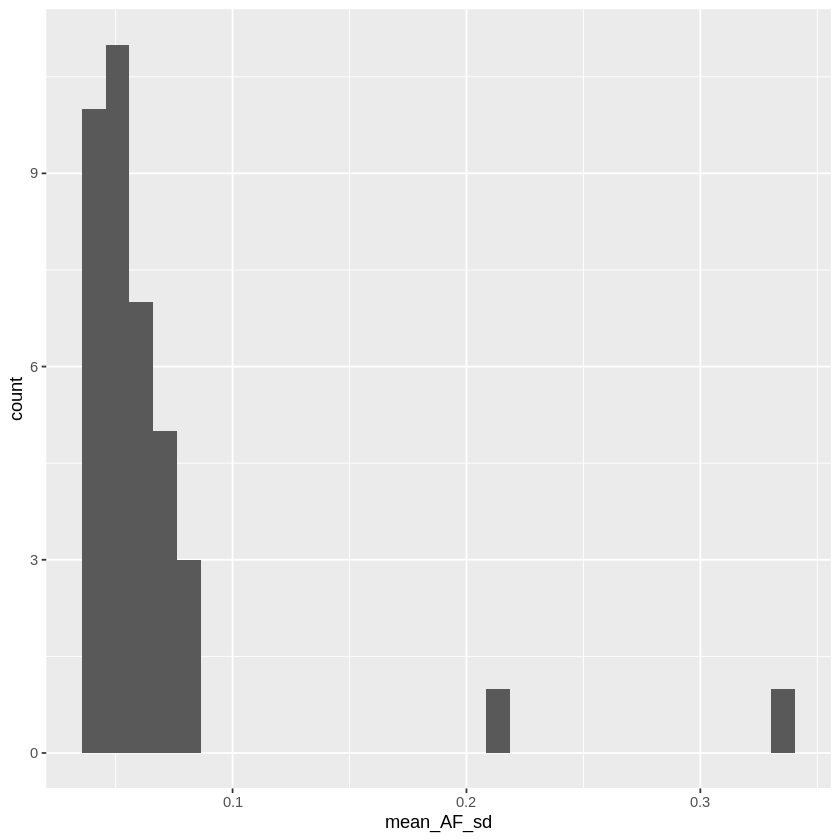

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


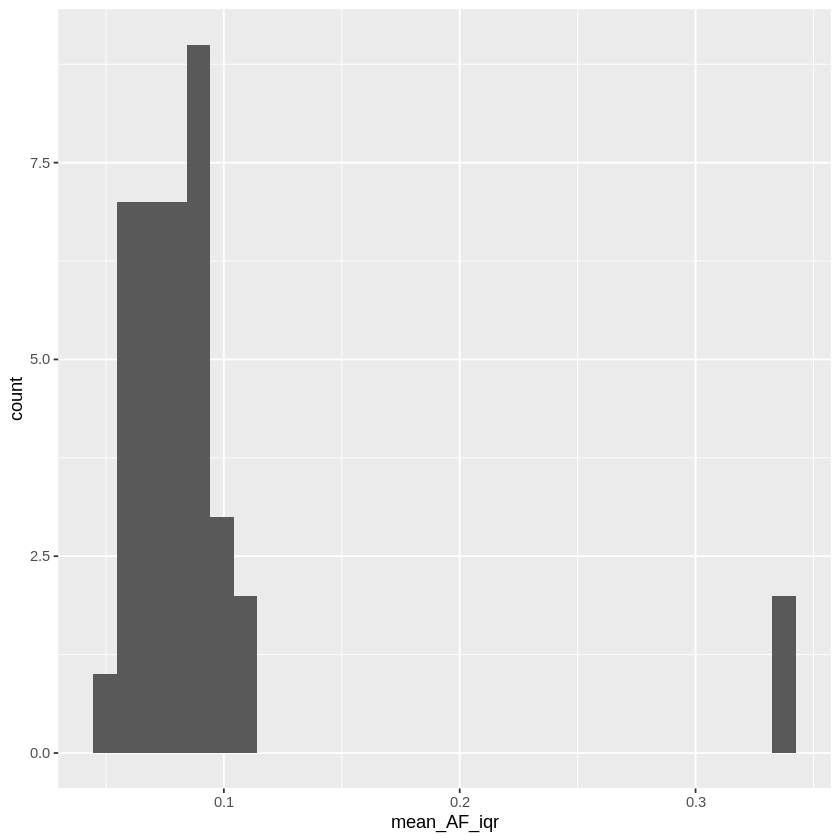

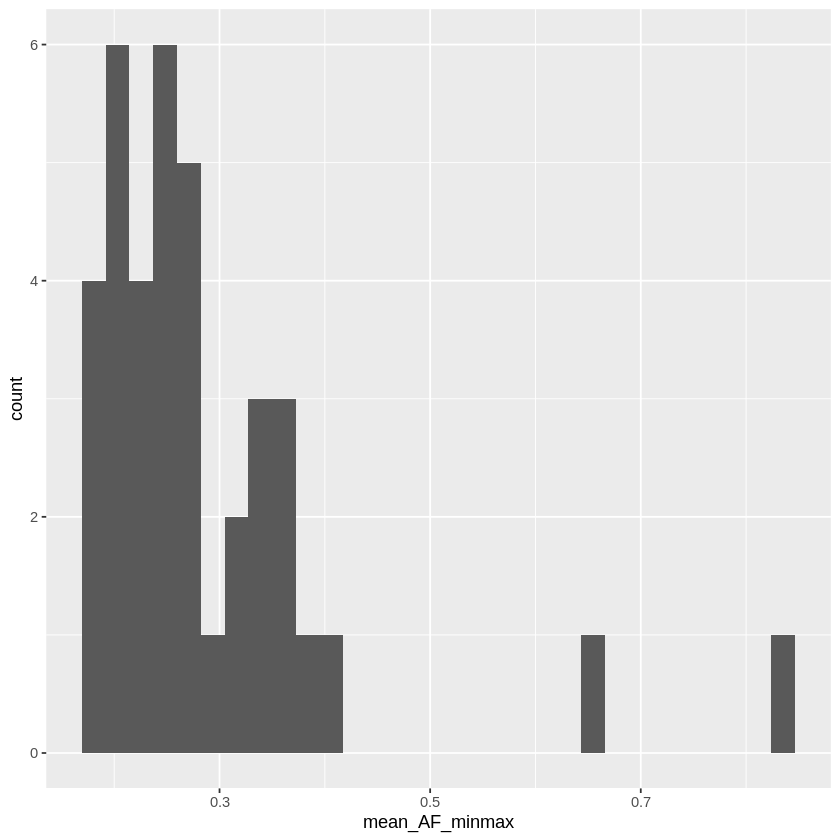

In [4]:
# how noisy is the data? this can be used to exclude crosses from further analyses
# should maybe be earlier in the pipeline...


# Sliding window function
compute_sd <- function(start, vec, window_size) {
  end <- start + window_size - 1
  if (end > length(vec)) return(NA)  # Return NA if window goes beyond vector length
  return(sd(vec[start:end], na.rm=TRUE))
}
compute_IQR <- function(start, vec, window_size) {
  end <- start + window_size - 1
  if (end > length(vec)) return(NA)  # Return NA if window goes beyond vector length
  return(IQR(vec[start:end], na.rm=TRUE))
}
compute_MinMax <- function(start, vec, window_size) {
  end <- start + window_size - 1
  if (end > length(vec)) return(NA)  # Return NA if window goes beyond vector length
  return(max(vec[start:end], na.rm=TRUE)-min(vec[start:end], na.rm=TRUE))
}
# Apply sliding window function
window_size <- 1000
step <- 10

AF_files<-list.files("/home/jnrunge/data/TRD/results/shiny","-AF.csv.gz$", full.names = TRUE)

AF_noisyness_df<-data.table()

for(i in 1:length(AF_files)){
    AF<-fread(AF_files[i])
    cross<-strsplit(basename(AF_files[i]),"-",fixed=TRUE)[[1]][1]
    cross

    AF<-mutate(AF, AF=AD_A1/sumCount)%>%pull(AF)


    results <- map_dbl(seq(1, length(AF), by = step), compute_sd, vec = AF, window_size = window_size)
    results2 <- map_dbl(seq(1, length(AF), by = step), compute_IQR, vec = AF, window_size = window_size)
    results3 <- map_dbl(seq(1, length(AF), by = step), compute_MinMax, vec = AF, window_size = window_size)

    # Remove NAs from the results
    results <- results[!is.na(results)]

    AF_noisyness_df<-bind_rows(AF_noisyness_df, data.table(cross=cross, mean_AF_sd=mean(results, na.rm=TRUE),
                                                          mean_AF_iqr=mean(results2, na.rm=TRUE),
                                                          mean_AF_minmax=mean(results3, na.rm=TRUE)))
}

ggplot(AF_noisyness_df, aes(mean_AF_sd))+
geom_histogram()
ggplot(AF_noisyness_df, aes(mean_AF_iqr))+
geom_histogram()
ggplot(AF_noisyness_df, aes(mean_AF_minmax))+
geom_histogram()

In [5]:
# the noisyness algorithms do not really help me get a result that makes visual sense, so I will just exclude crosses based on visual deduction

excluded_crosses<-c("YJNRC29","YJNRC30","YJNRC31","YJNRC32","YJNRC4","YJNRC9")
One_Table<-filter(One_Table, !(cross %in% excluded_crosses))

In [6]:
get_and_plot_AF=function(OT_slice, plot=TRUE){
    AF_file<-paste0("/home/jnrunge/data/TRD/results/shiny/",pull(OT_slice, cross),"-AF.csv.gz")
    AF<-fread(AF_file)
    extended_by<-200000
    AF_extended<-filter(AF, chr==pull(OT_slice,chr) & global_pos >= (pull(OT_slice, global_start)-extended_by) & global_pos <= (pull(OT_slice, global_end)+extended_by))
    
    # make sure the model is centered (0) at the midpoint for ideal fitting (?) or most comparable fitting between loci
    mid <- (pull(OT_slice, global_start) + pull(OT_slice, global_end)) / 2

    
    AF_extended <- AF_extended %>%
      mutate(diff = abs(global_pos - mid)) %>%     # Compute absolute difference for each row
      mutate(midpoint = ifelse(diff == min(diff), TRUE, FALSE)) %>%  # Set midpoint column
      select(-diff)                               # Remove the temporary difference column

    AF<-filter(AF, chr==pull(OT_slice,chr) & global_pos >= pull(OT_slice, global_start) & global_pos <= pull(OT_slice, global_end))
    AF_values<-pull(AF,AD_A1)/pull(AF,sumCount)
    AF_value<-mean(AF_values)
    
    
    AF_values_extended<-pull(AF_extended,AD_A1)/pull(AF_extended,sumCount)
    
    # standardized positioning for comparable model fits
    
    AF_positions<-(1:length(AF_values_extended))/length(AF_values_extended)
    # correct so that 0 is where the midpoint is
    AF_positions_zero<-which(pull(AF_extended, midpoint))
    AF_positions<-AF_positions-AF_positions[AF_positions_zero]
    
    AF_here<-data.table(pos=AF_positions, AF=AF_values_extended)
    summary(AF_lm<-lm(AF~poly(pos,2),AF_here))
    AF_lm_poly1<-lm(AF~pos, AF_here)
    AF_here<-mutate(AF_here,predict=predict(AF_lm))
    
    if(plot==TRUE){
        return(ggplot(AF_here, aes(pos, AF))+
            geom_point()+geom_line(aes(pos,predict))+ggtitle(paste(pull(OT_slice, cross),
                                                          pull(OT_slice, ID))))
    }
    
    return(list(AF_value,
               AF_lm, AF_lm_poly1, anova(AF_lm_poly1,AF_lm)))
}

In [7]:
summary(get_and_plot_AF(filter(One_Table, paste(cross, ID)=="ChrisC1 9"), FALSE)[[2]]$residuals)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.1545924 -0.0461782  0.0003621  0.0000000  0.0450761  0.1493456 

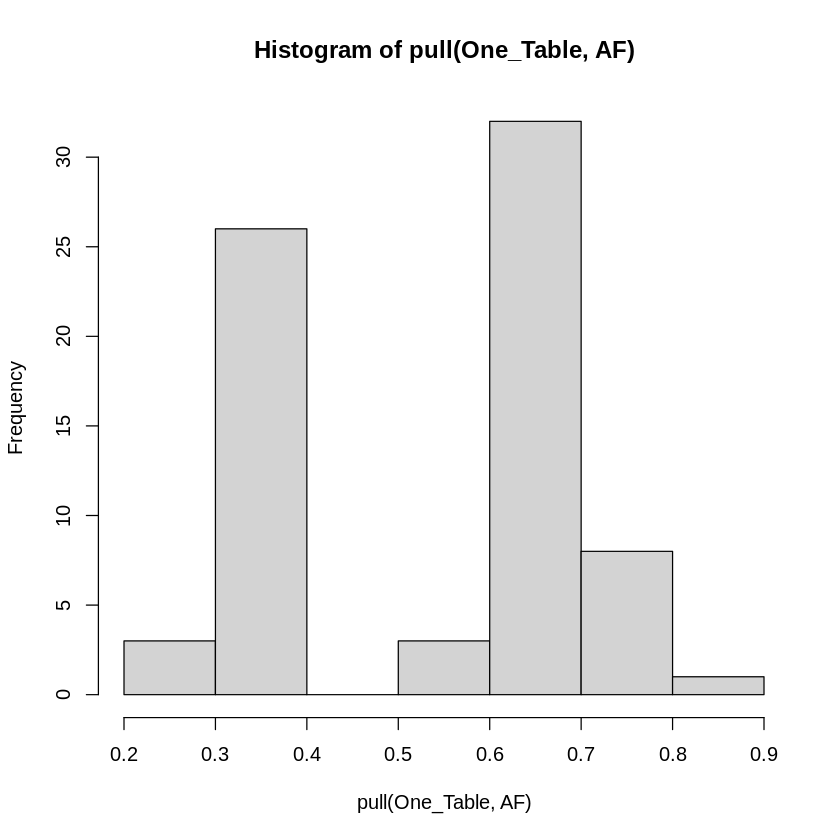

In [8]:
# I will also exclude TRD that do not rise and fall or that span entire chromosomes


# &

# we need to know which direction the distortion is and how strong it is
# to distinguish different cases

# just add AF to all TRD regions

One_Table<-mutate(One_Table, AF=NA, AF_lm_int=NA, AF_lm_poly1=NA, AF_lm_poly2=NA, AF_lm_r2=NA, AF_lm_anova=NA, AF_lm_anova_RSS=NA, AF_lm_poly1_1=NA,
                 AF_lm_resid_median=NA)

for(i in 1:nrow(One_Table)){
    OT_slice<-slice(One_Table, i)
    AF_values<-get_and_plot_AF(OT_slice,FALSE)
    AF_value<-AF_values[[1]]
    AF_lm<-AF_values[[2]]
    AF_lm_p1<-AF_values[[3]]
    AF_lm_anova_val<-AF_values[[4]]
    
    One_Table<-mutate(One_Table, AF=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),
                                           AF_value, AF),
                     AF_lm_int=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),AF_lm$coefficients[1],
                              AF_lm_int),
                     AF_lm_poly1=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),AF_lm$coefficients[2],
                              AF_lm_poly1),
                     AF_lm_poly2=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),AF_lm$coefficients[3],
                              AF_lm_poly2),
                      AF_lm_r2=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),summary(AF_lm)$r.squared,
                              AF_lm_r2),
                      AF_lm_resid_median=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),median(AF_lm$residuals),
                              AF_lm_resid_median),
                      AF_lm_anova=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),AF_lm_anova_val$`Pr(>F)`[2],
                              AF_lm_anova),
                                        AF_lm_anova_RSS=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),AF_lm_anova_val$`Sum of Sq`[2],
                              AF_lm_anova_RSS),
                      AF_lm_poly1_1=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),AF_lm_p1$coefficients[2],
                              AF_lm_poly1_1)
                     )
}

hist(pull(One_Table, AF))

One_Table<-mutate(One_Table, Distorter=ifelse(AF>0.5,"1","2"))

In [9]:
# this was an initial set of visually inferred TRD loci

bad_TRD_visual_inference<-c("ChrisC4 2","YJNRC12 1","YJNRC12 2",
                            "YJNRC17 8", "YJNRC21 3", "YJNRC24 3",
                            "YJNRC24 4", "YJNRC24 5", "YJNRC24 6",
                            "YJNRC7 4", "YJNRC8 7")

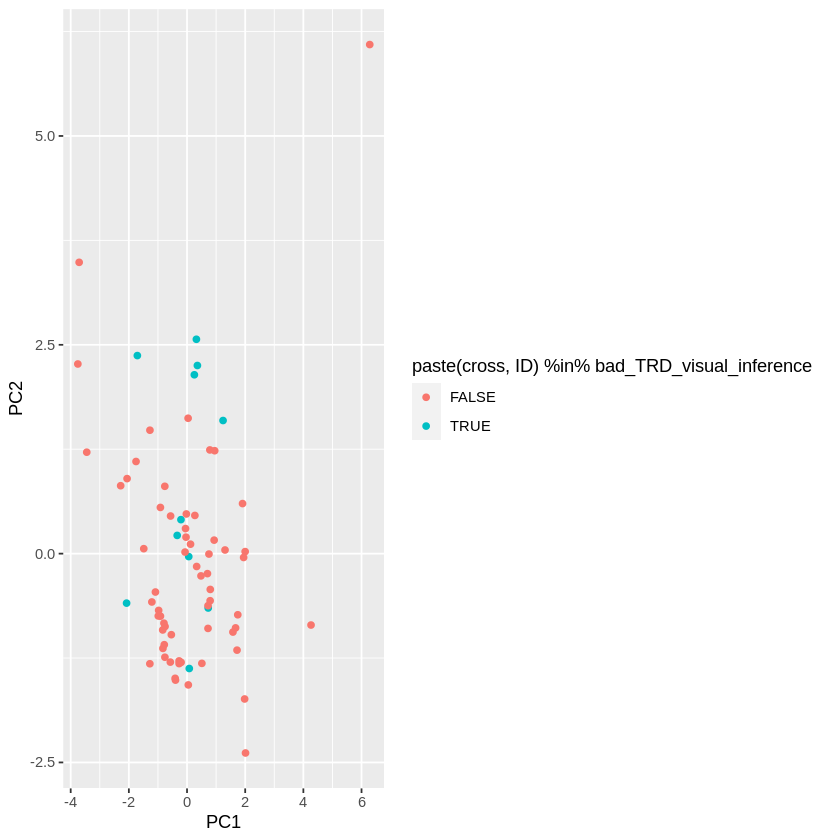

In [10]:
AF_lm_PCA<-prcomp(select(One_Table, AF_lm_int, AF_lm_poly1, AF_lm_poly2, AF_lm_r2, AF_lm_anova,
                        AF_lm_anova_RSS,AF_lm_resid_median,
                        AF_lm_poly1_1)%>%mutate(AF_lm_int=as.numeric(scale(AF_lm_int)),
                                                                                           AF_lm_poly1=as.numeric(scale(AF_lm_poly1)),
                                                                                           AF_lm_poly2=as.numeric(scale(AF_lm_poly2)),
                                                                                           AF_lm_r2=as.numeric(scale(AF_lm_r2)),
                                                                                            AF_lm_anova_RSS=as.numeric(scale(AF_lm_anova_RSS)),
                                                                                            AF_lm_anova=as.numeric(scale(AF_lm_anova)),
                                                AF_lm_resid_median=as.numeric(scale(AF_lm_resid_median)),
                                               AF_lm_poly1_1=as.numeric(scale(AF_lm_poly1_1))))$x
AF_lm_PCA<-as.data.frame(AF_lm_PCA)
ggplot(bind_cols(One_Table,AF_lm_PCA), aes(PC1, PC2,
                                          color=paste(cross, ID)%in%bad_TRD_visual_inference))+
geom_point()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


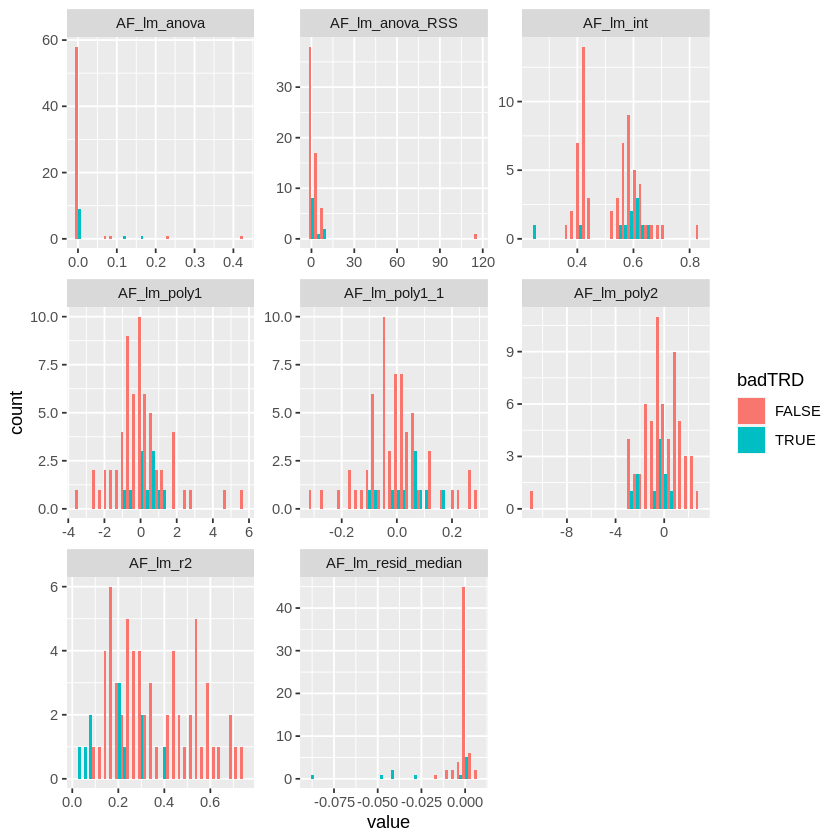

In [11]:
ggplot(pivot_longer(mutate(One_Table, badTRD=paste(cross, ID)%in%bad_TRD_visual_inference),
                    c(AF_lm_int, AF_lm_poly1, AF_lm_poly2, AF_lm_r2,AF_lm_anova, AF_lm_anova_RSS, AF_lm_poly1_1,AF_lm_resid_median)),
       aes(value, fill=badTRD))+facet_wrap(~name, scales="free")+
       geom_histogram(position="dodge")

In [12]:
# filter out bad TRD loci

One_Table<-mutate(One_Table, polynomial_filtered_out=FALSE) # TRUE == remove

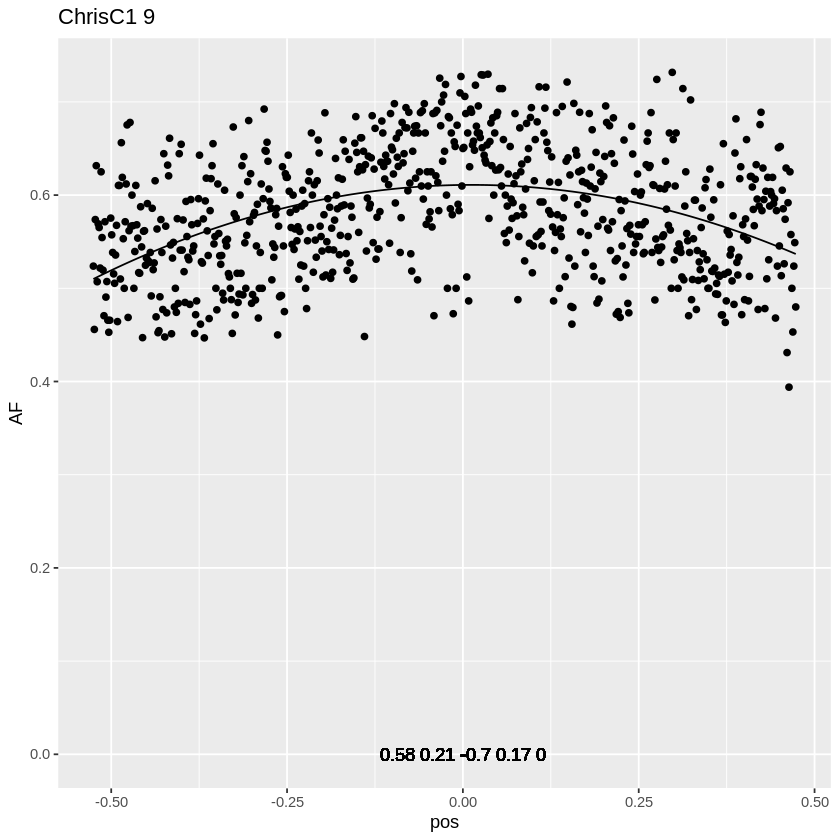

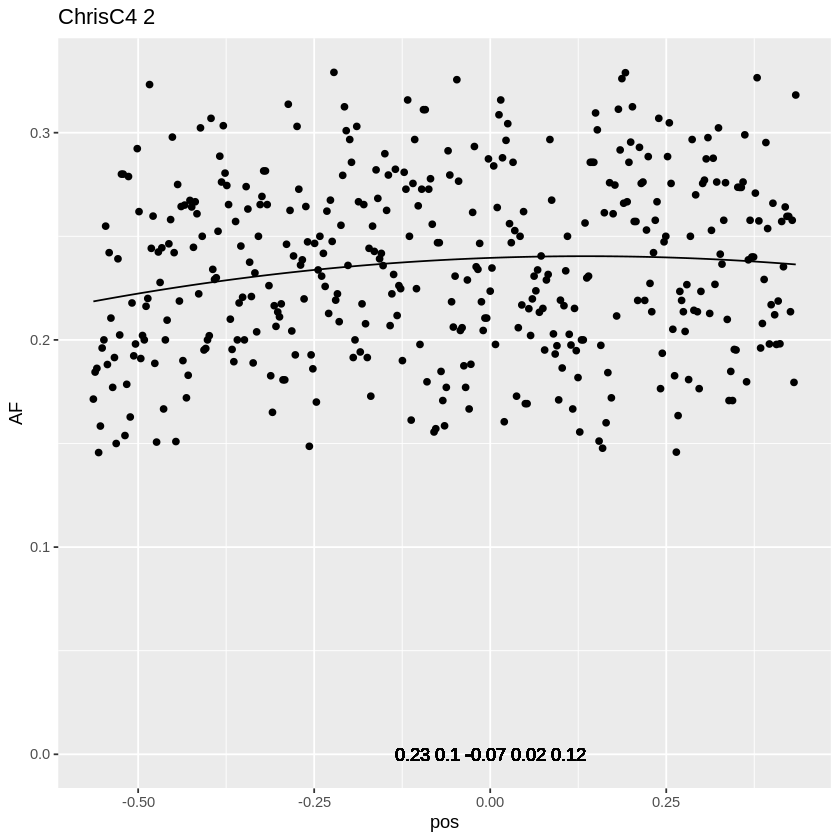

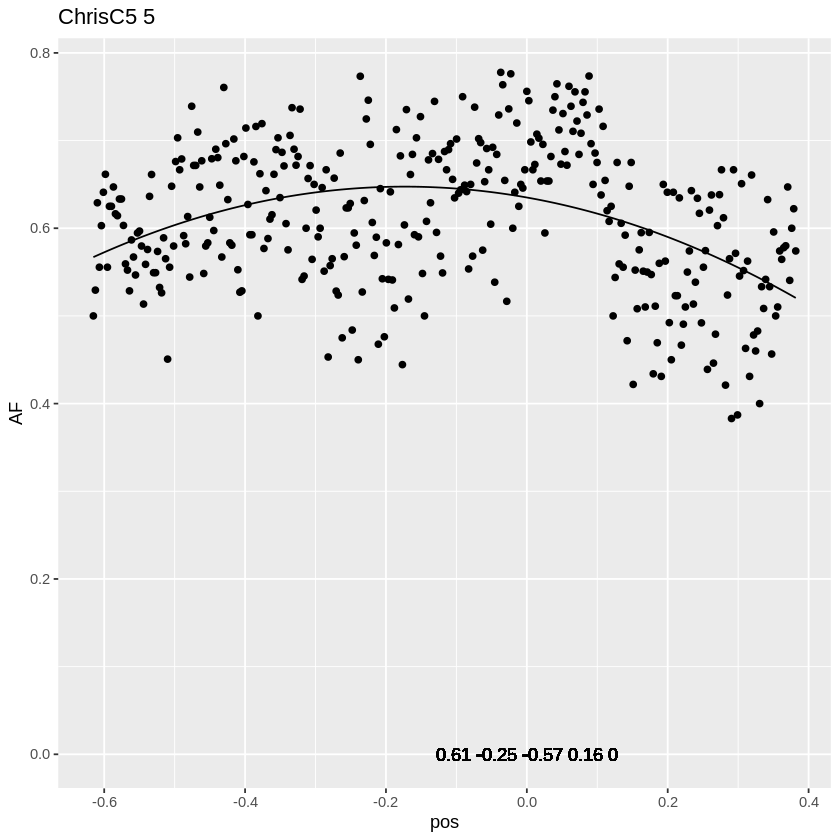

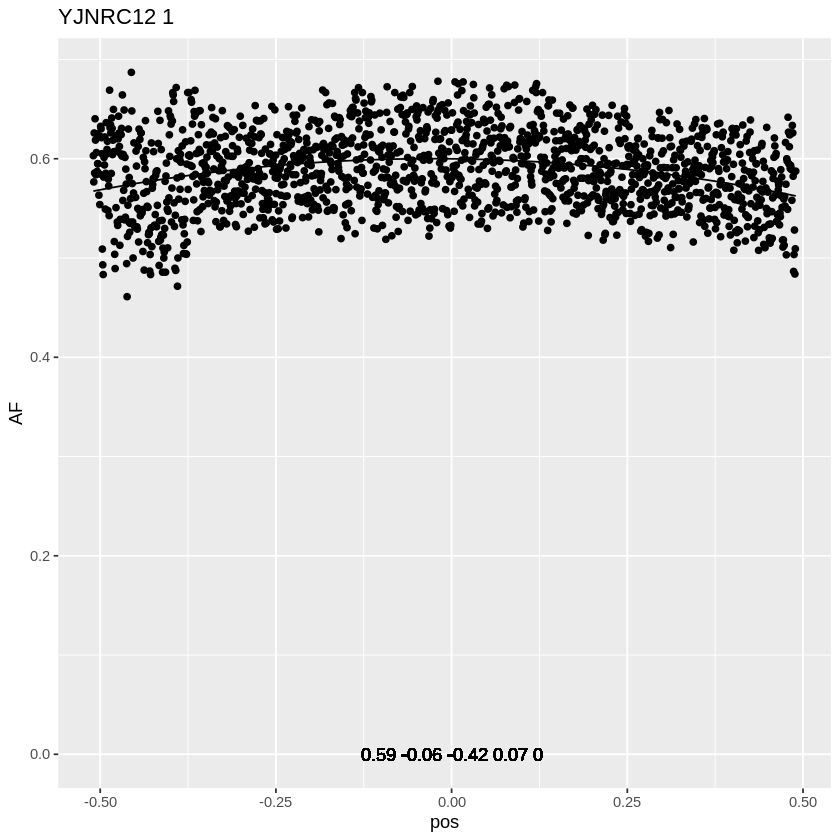

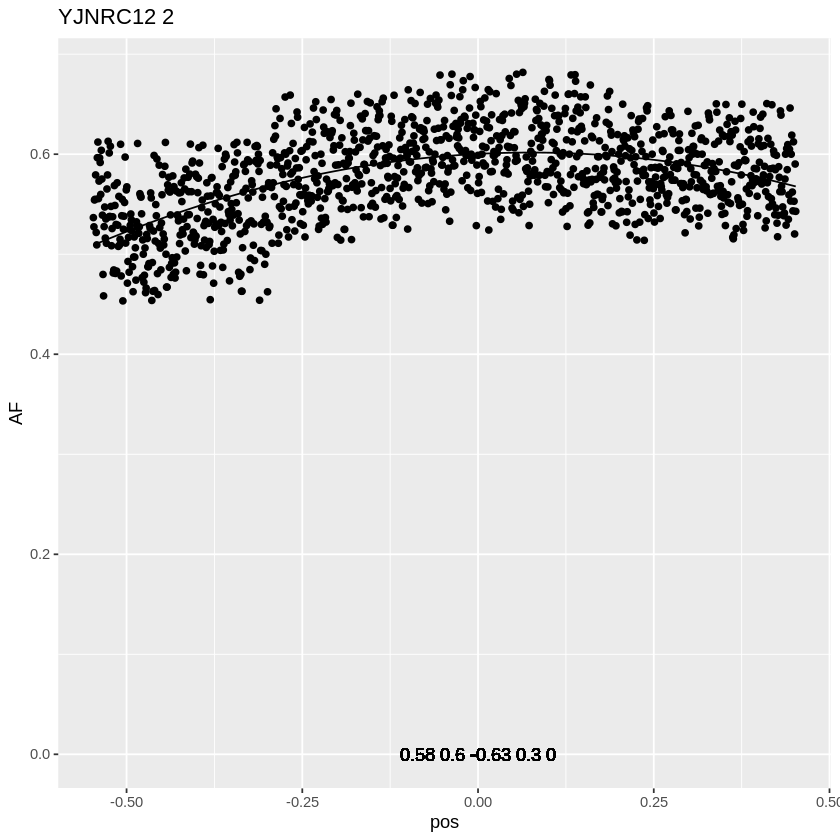

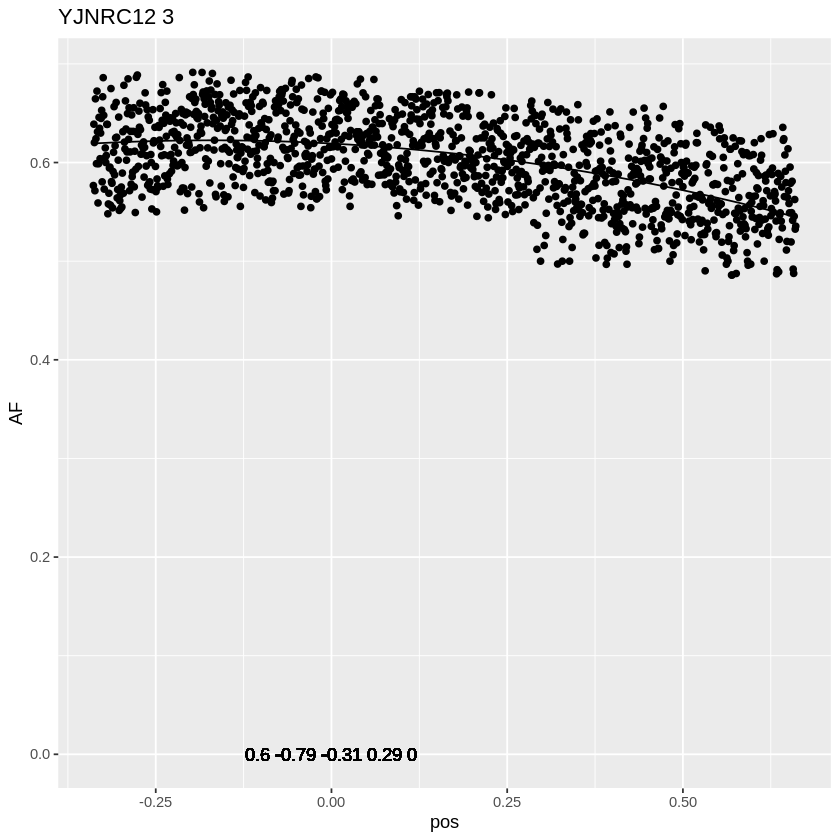

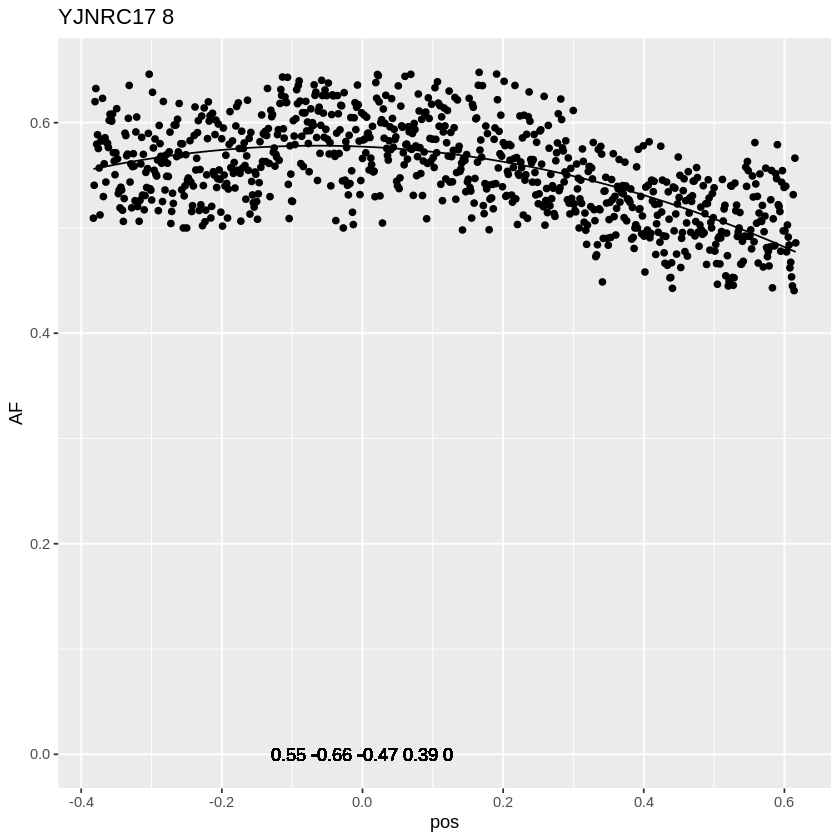

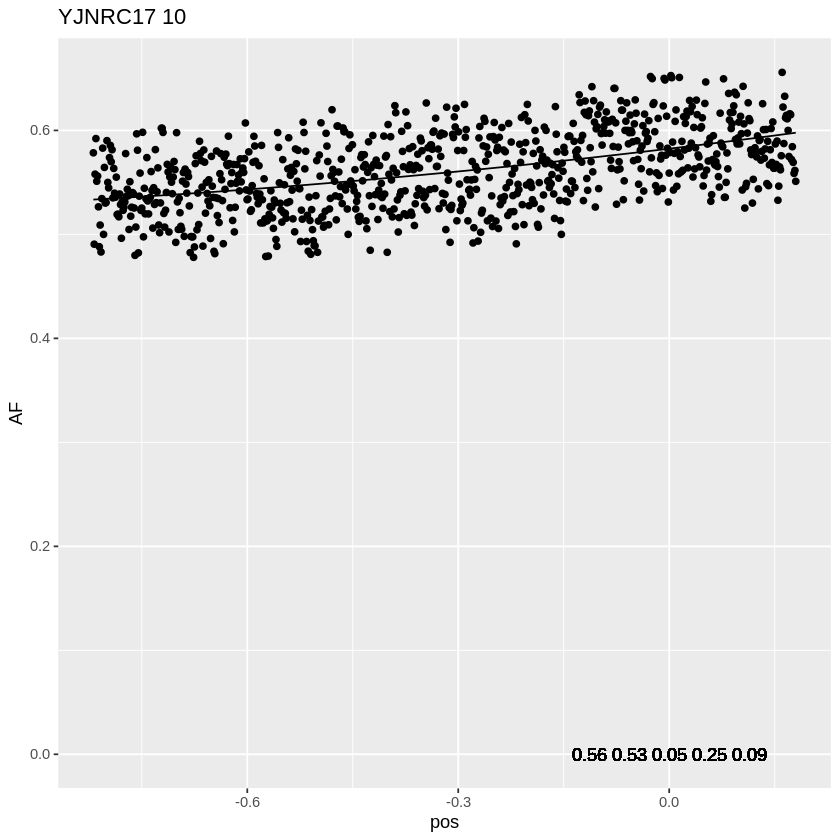

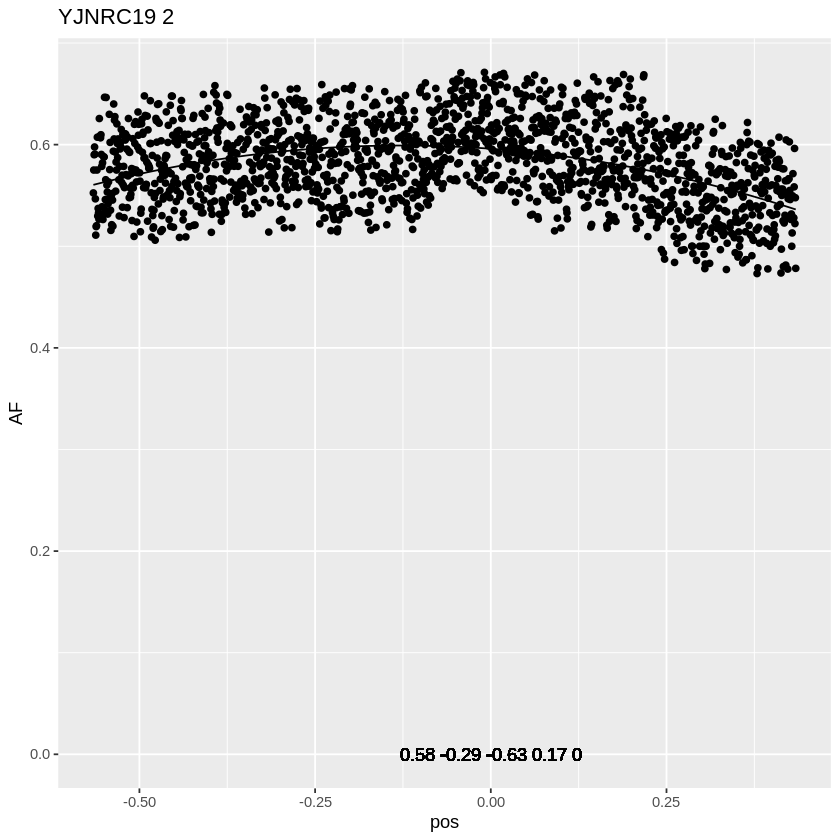

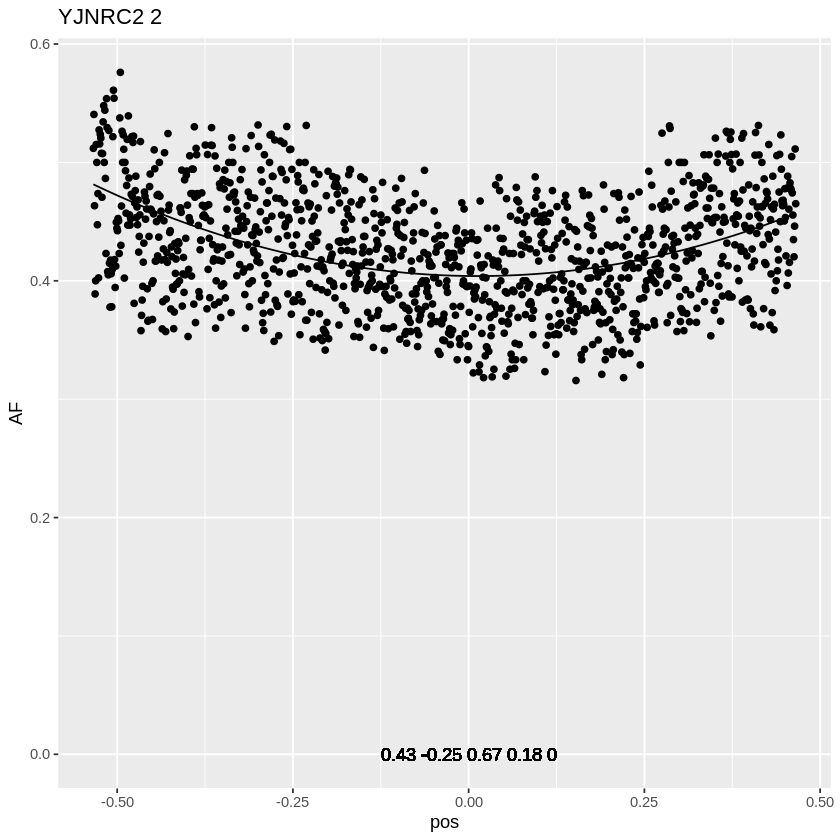

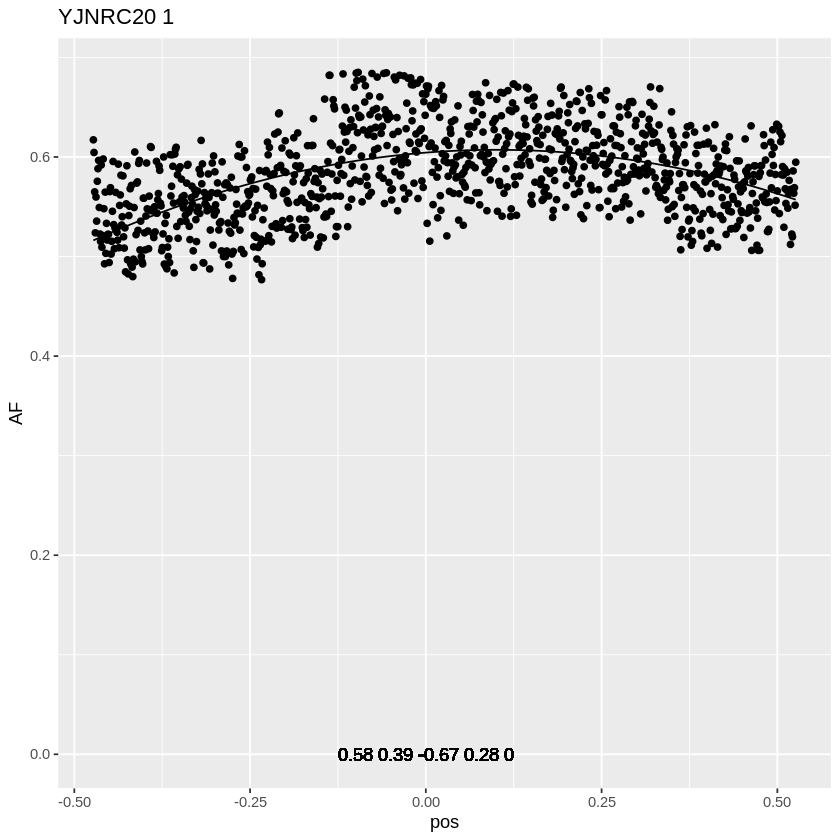

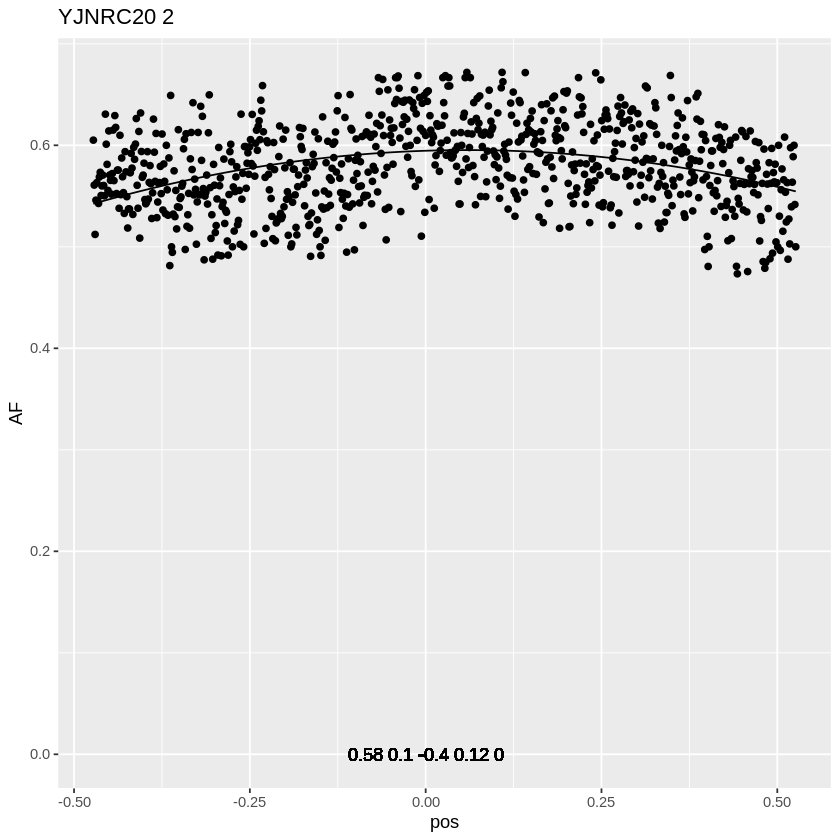

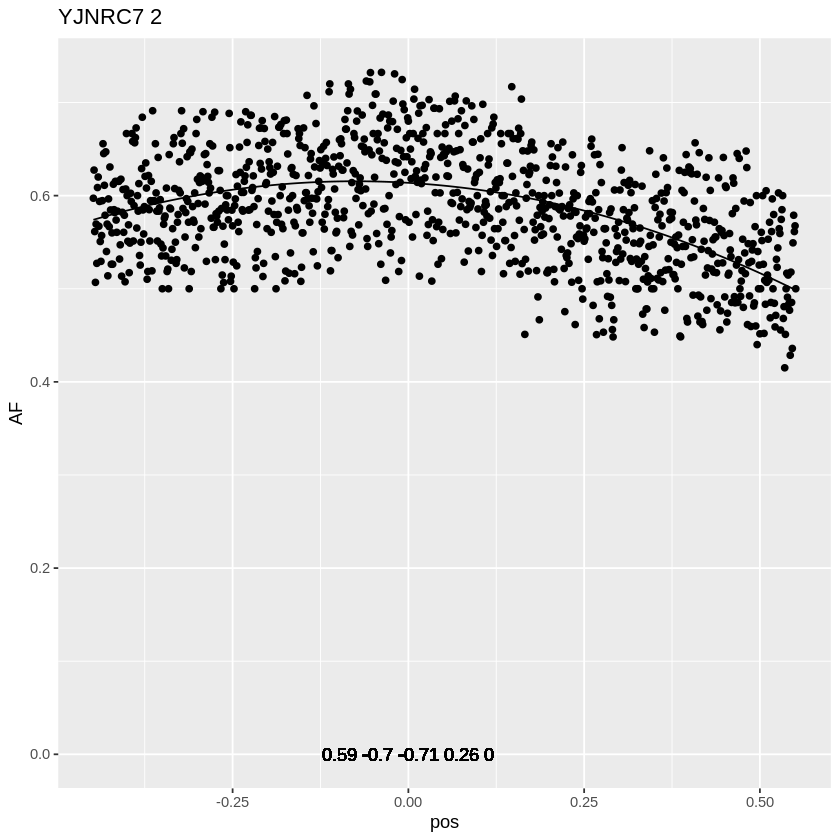

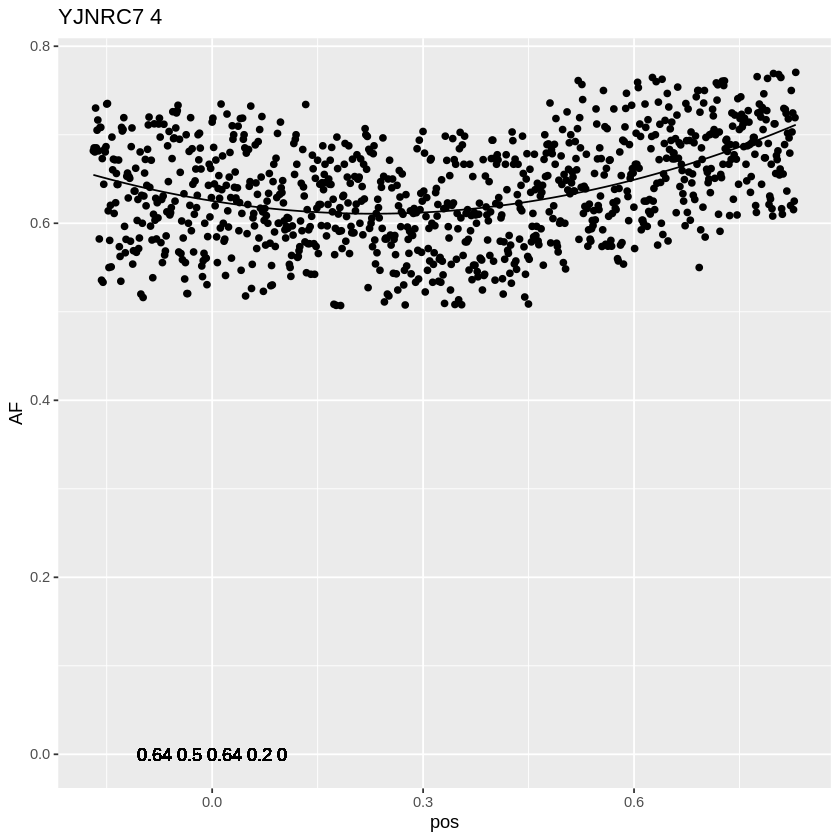

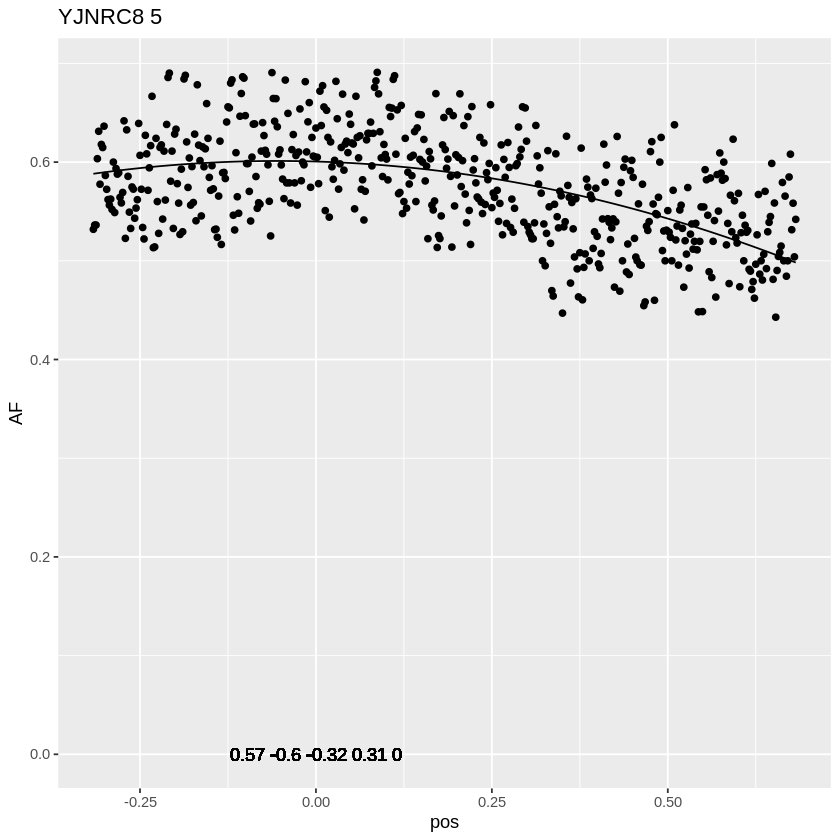

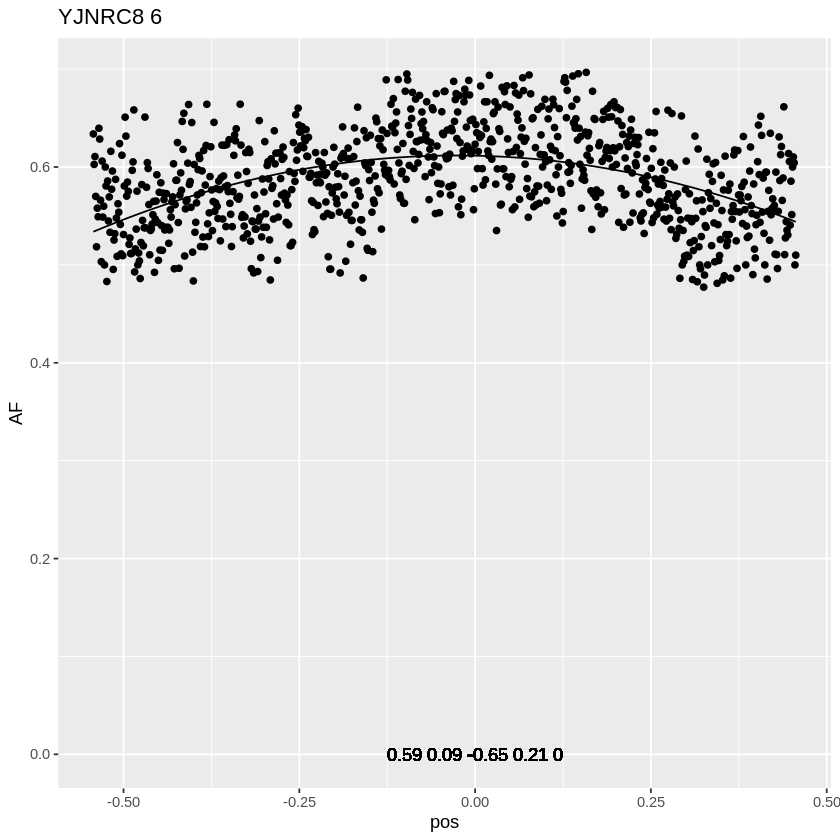

In [13]:
# flat regions

val<-0.8

for(i in which(abs(pull(One_Table, AF_lm_poly1_1))<val&
              abs(pull(One_Table, AF_lm_poly1))<val&
              abs(pull(One_Table, AF_lm_poly2))<val)){
    
    One_Table<-mutate(One_Table, polynomial_filtered_out=ifelse(row_number()==i, TRUE, polynomial_filtered_out))
    
    print(get_and_plot_AF(slice(One_Table,i))+geom_text(mapping=aes(0,0,label=paste(round(pull(slice(One_Table,i), AF_lm_int),2),
                                                                             round(pull(slice(One_Table,i), AF_lm_poly1),2),
                                                                             round(pull(slice(One_Table,i), AF_lm_poly2),2),
                                                                             round(pull(slice(One_Table,i), AF_lm_r2),2),
                                                                                   round(pull(slice(One_Table,i), AF_lm_anova),2)))))
}

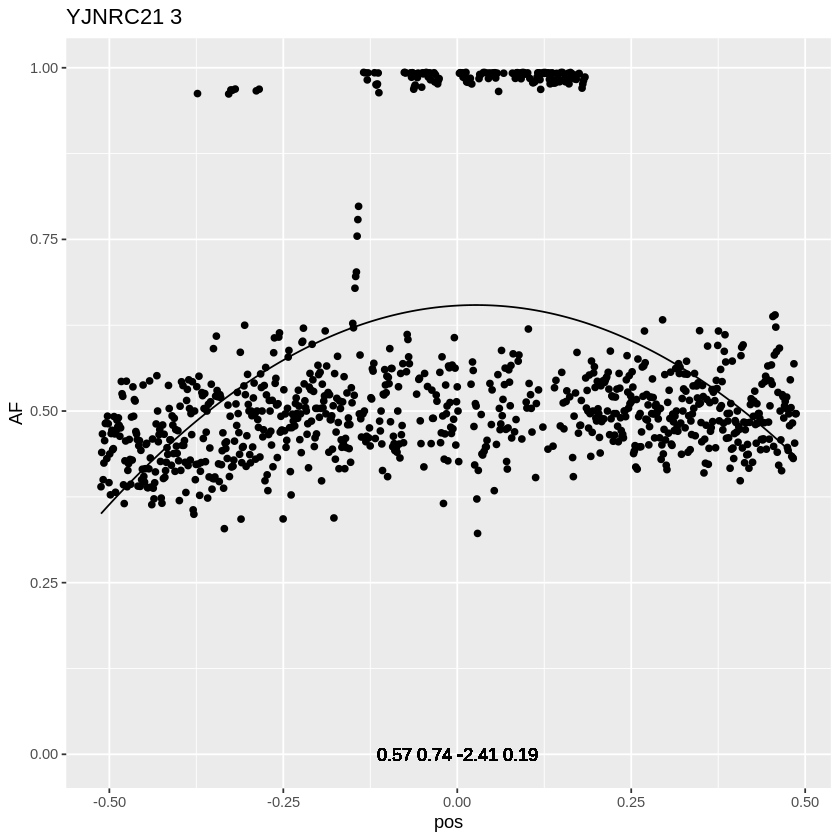

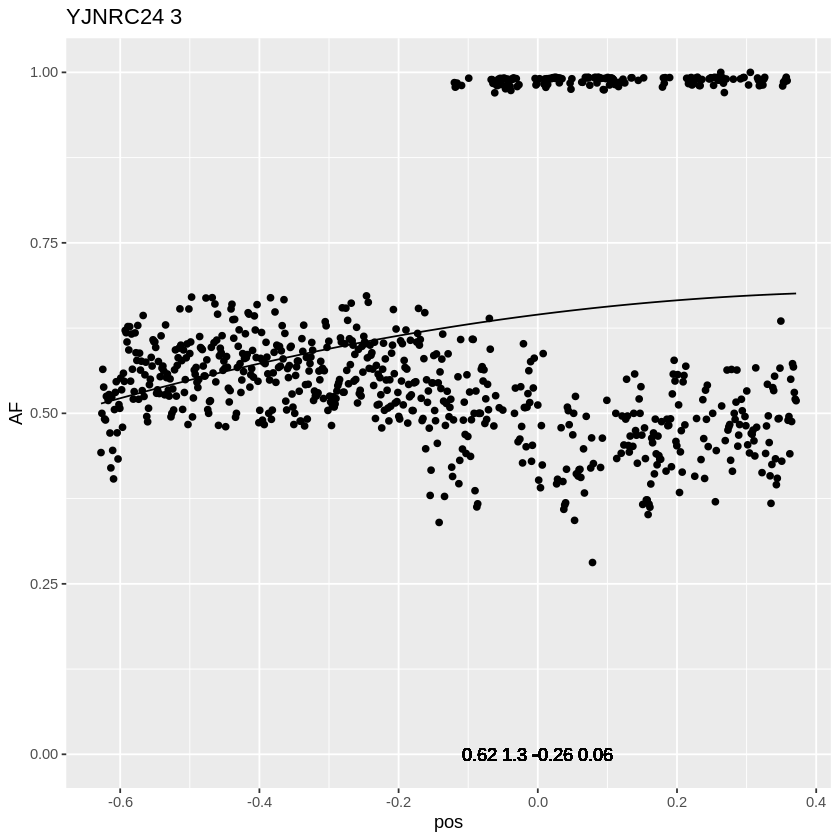

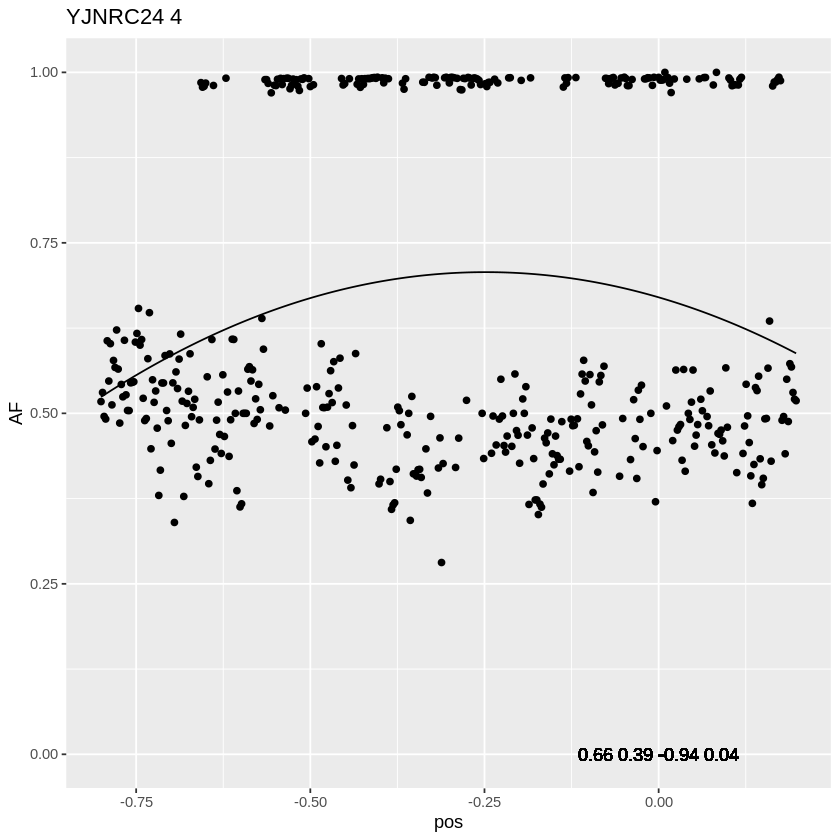

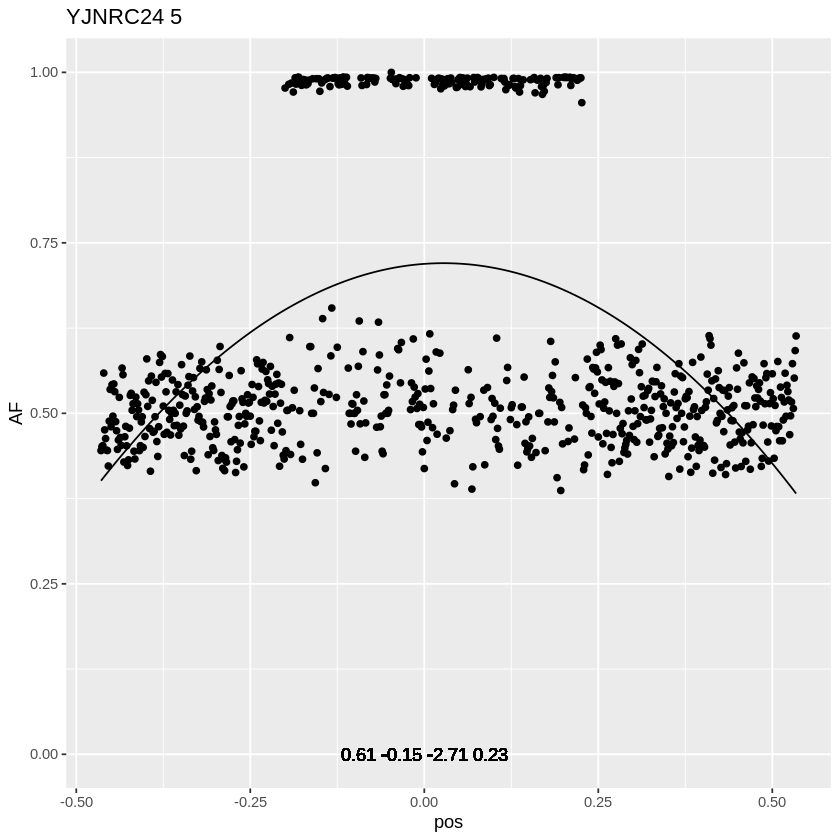

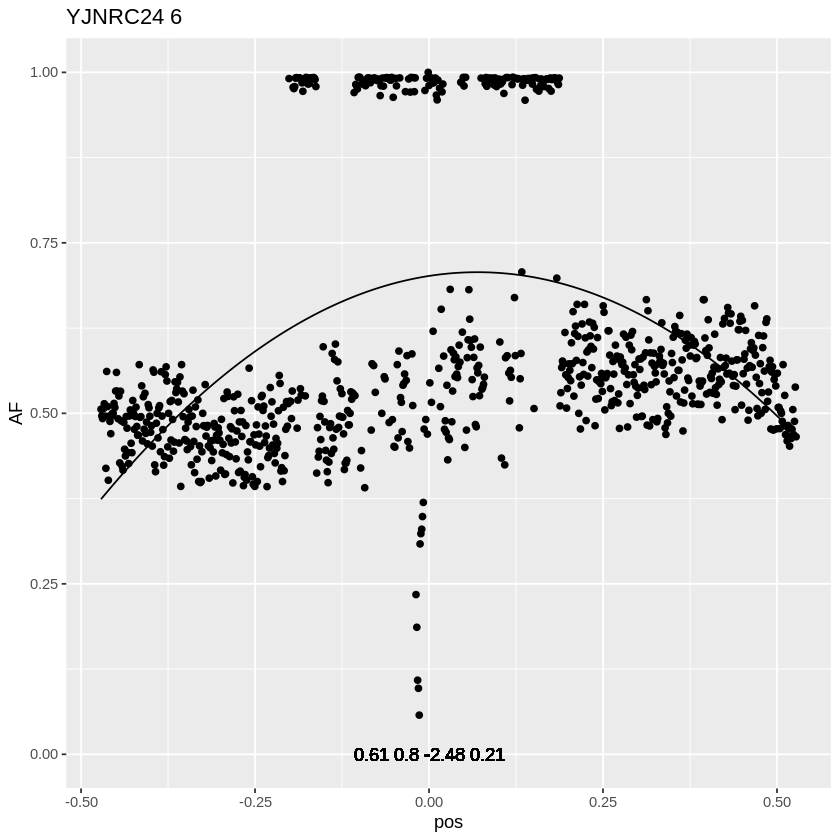

In [14]:
# bad fit

for(i in which(abs(pull(One_Table, AF_lm_resid_median))>0.02)){
    One_Table<-mutate(One_Table, polynomial_filtered_out=ifelse(row_number()==i, TRUE, polynomial_filtered_out))
    print(get_and_plot_AF(slice(One_Table,i))+geom_text(mapping=aes(0,0,label=paste(round(pull(slice(One_Table,i), AF_lm_int),2),
                                                                             round(pull(slice(One_Table,i), AF_lm_poly1),2),
                                                                             round(pull(slice(One_Table,i), AF_lm_poly2),2),
                                                                             round(pull(slice(One_Table,i), AF_lm_r2),2)))))
}

polynomial_filtered_out,bad_viz_inf,n
<lgl>,<lgl>,<int>
FALSE,FALSE,51
FALSE,TRUE,1
TRUE,FALSE,11
TRUE,TRUE,10


ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,PCA_eucldist_quantile_1,...,AF_lm_poly1,AF_lm_poly2,AF_lm_r2,AF_lm_anova,AF_lm_anova_RSS,AF_lm_poly1_1,AF_lm_resid_median,Distorter,polynomial_filtered_out,bad_viz_inf
<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>
7,115,chromosome15,10192979,10244627,51648,YJNRC8,273227,324875,0.8203242,...,-0.8429246,0.1795785,0.2863155,0.0001137534,0.03224844,-0.0992249,-0.002680573,2,FALSE,TRUE


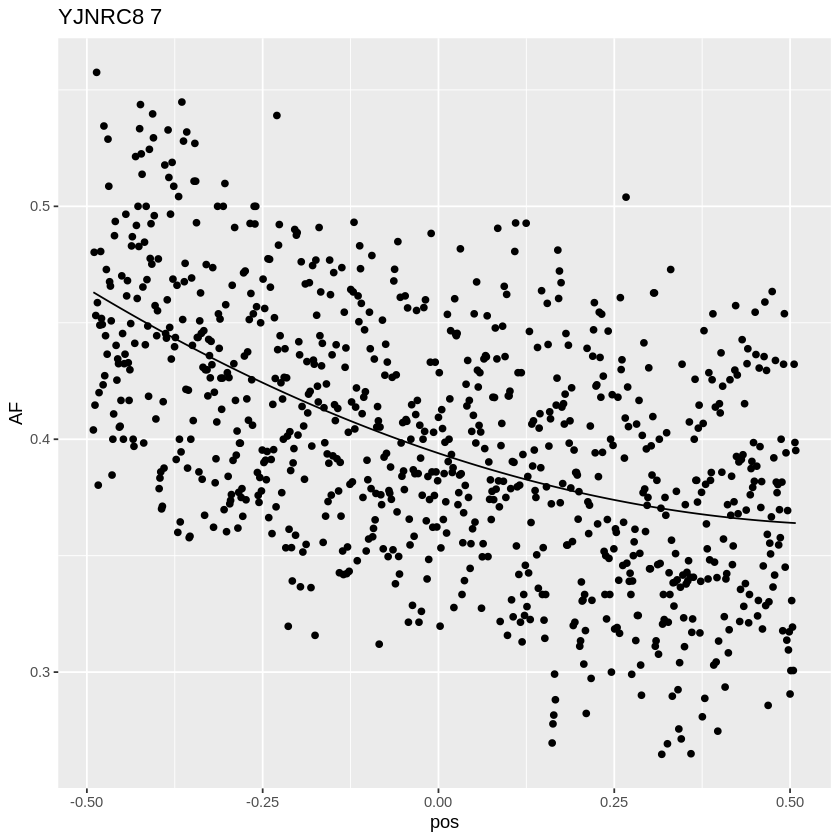

In [15]:
summarize(group_by(One_Table<-One_Table%>%mutate(bad_viz_inf=paste(cross, ID)%in%bad_TRD_visual_inference), polynomial_filtered_out, bad_viz_inf),
          n=n())

filter(One_Table, bad_viz_inf==TRUE & polynomial_filtered_out==FALSE)

get_and_plot_AF(filter(One_Table, bad_viz_inf==TRUE & polynomial_filtered_out==FALSE))

In [16]:
One_Table<-filter(One_Table, polynomial_filtered_out==FALSE)

In [17]:
SV_data_summary<-filter(SV_data_summary, paste(cross,ID)%in% paste(pull(One_Table, cross), pull(One_Table, ID)))

In [18]:
SV_data_summary_parent_v_parent<-SV_data_summary%>%group_by(cross,ID,TYPE)%>%summarize(LEN_rel_diff_abs=abs(sum_LEN_rel[1]-sum_LEN_rel[2]))
head(SV_data_summary_parent_v_parent)
filter(SV_data_summary_parent_v_parent, is.na(LEN_rel_diff_abs))

cross,ID,TYPE,LEN_rel_diff_abs
<chr>,<chr>,<chr>,<dbl>
ChrisC1,1,CONTR,0
ChrisC1,1,DEL,0
ChrisC1,1,DUP,0
ChrisC1,1,INS,0
ChrisC1,1,INV,0
ChrisC1,1,TRA,0


cross,ID,TYPE,LEN_rel_diff_abs
<chr>,<chr>,<chr>,<dbl>


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


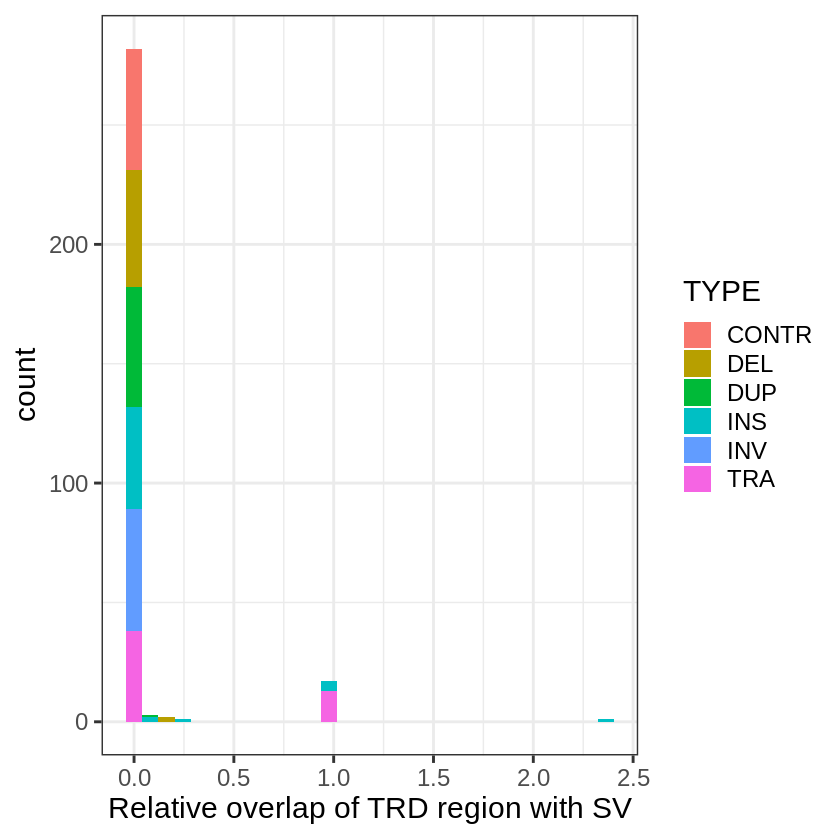

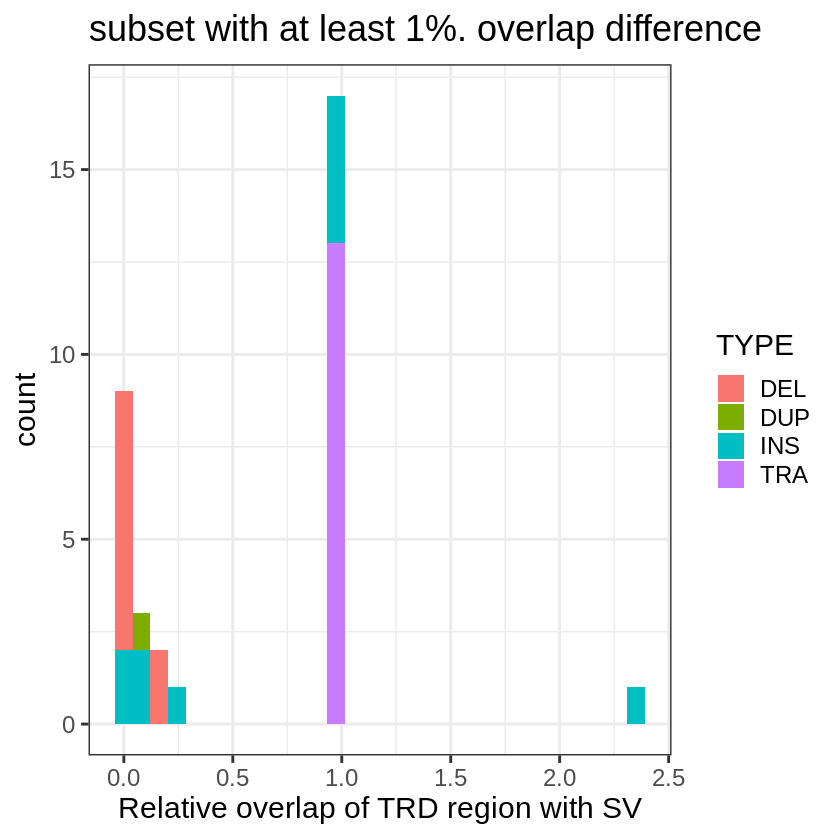

In [19]:
# What sort of SVs are involved?

library(ggplot2)
ggplot(SV_data_summary_parent_v_parent, aes(LEN_rel_diff_abs, fill=TYPE))+
geom_histogram()+
#facet_wrap(~source)+#+scale_y_log10()
theme_bw(18)+
xlab("Relative overlap of TRD region with SV")

library(ggplot2)
ggplot(SV_data_summary_parent_v_parent%>%filter(LEN_rel_diff_abs>0.01), aes(LEN_rel_diff_abs, fill=TYPE))+
geom_histogram()+
#facet_wrap(~source)+#+scale_y_log10()
theme_bw(18)+
xlab("Relative overlap of TRD region with SV")+ggtitle("subset with at least 1%. overlap difference")

In [20]:
# add a column that says if this TRD if this cross's strongest TRD

One_Table <- One_Table %>% 
  group_by(cross) %>%
  mutate(strongest = abs(AF - 0.5) == max(abs(AF - 0.5), na.rm = TRUE)) %>%
  ungroup()


Call:
lm(formula = tree_changes_raw ~ log(lengthBp), data = One_Table)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.46689 -0.15303 -0.00452  0.07487  1.05773 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    9.38814    0.57415   16.35   <2e-16 ***
log(lengthBp) -0.56921    0.04723  -12.05   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2304 on 50 degrees of freedom
Multiple R-squared:  0.7439,	Adjusted R-squared:  0.7388 
F-statistic: 145.2 on 1 and 50 DF,  p-value: < 2.2e-16


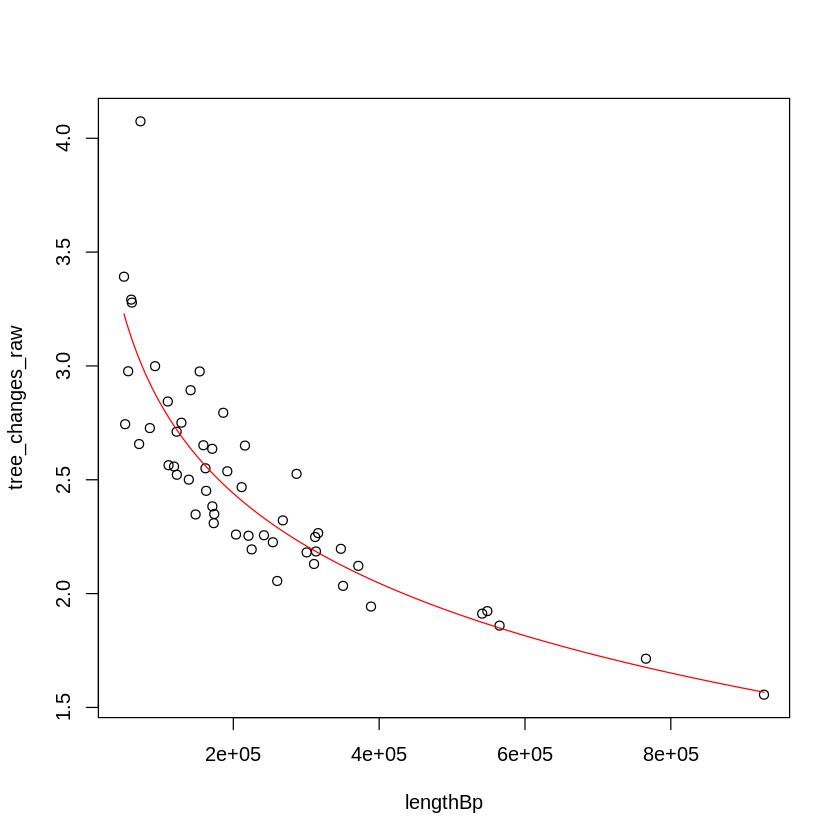

In [21]:
# quick evidence that tree changes at TRD locus needed to be corrected for size of TRD region
# the necessary changes have been made to 02_Local-Phylogeny now.

poly_model <- lm(tree_changes_raw ~ log(lengthBp), data = One_Table)
summary(poly_model)
x <- with(One_Table, seq(min(lengthBp), max(lengthBp), length.out=2000))
y <- predict(poly_model, newdata = data.frame(lengthBp = x))

plot(tree_changes_raw ~ lengthBp, data = One_Table)
lines(x, y, col = "red")

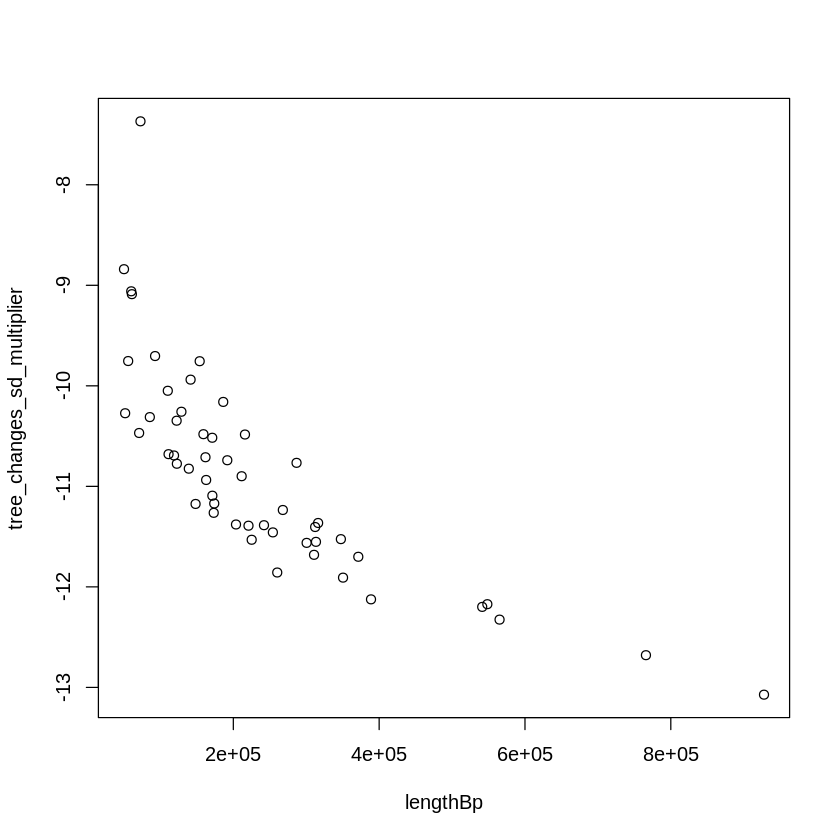

In [22]:
plot(tree_changes_sd_multiplier ~ lengthBp, data = One_Table)


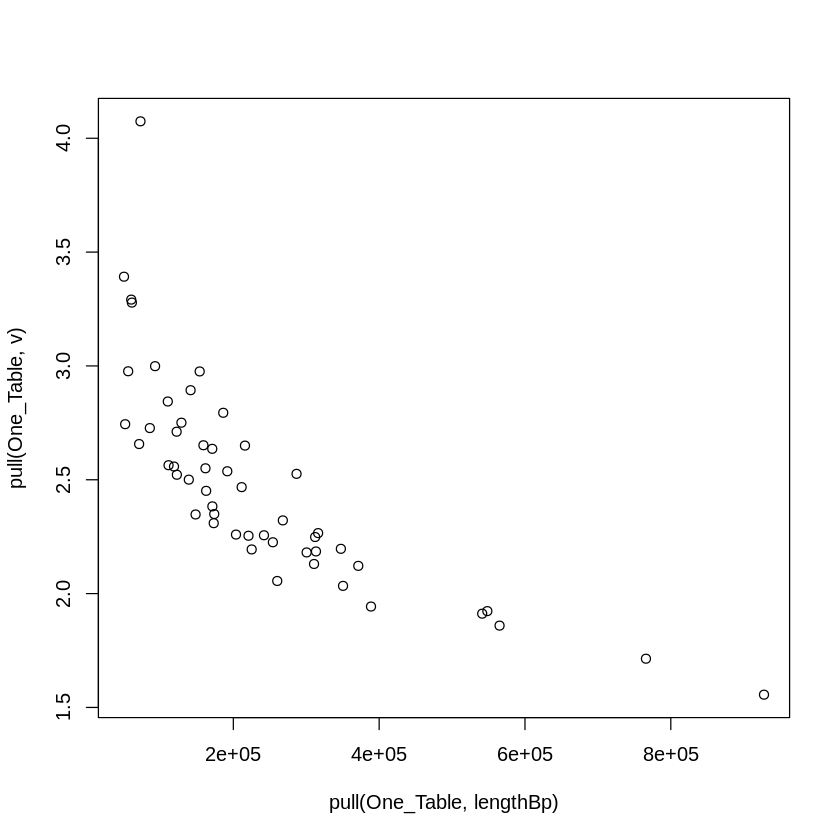

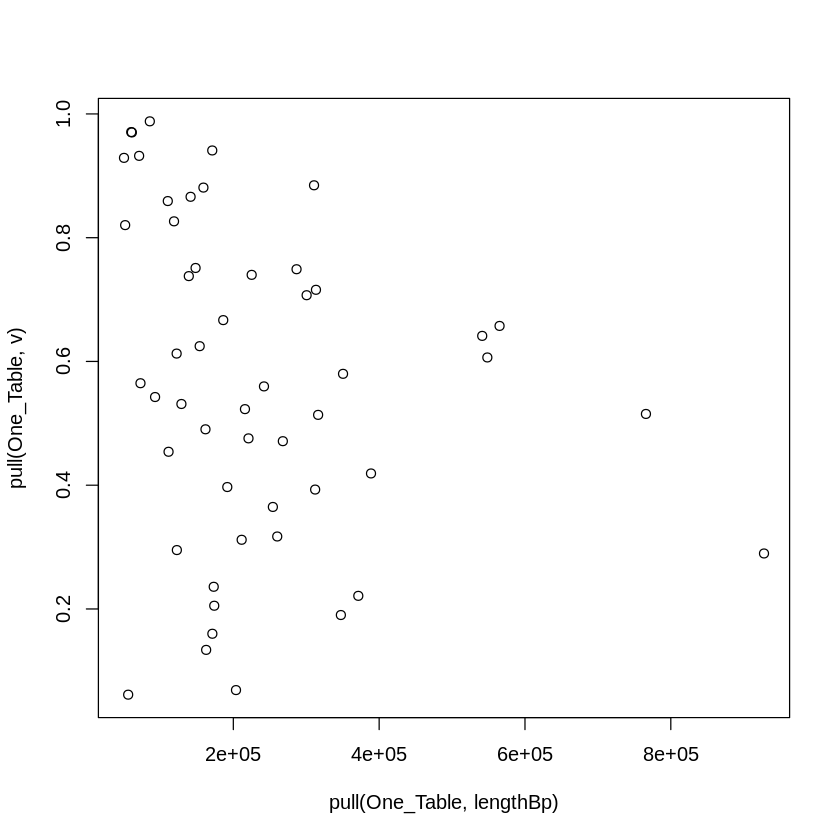

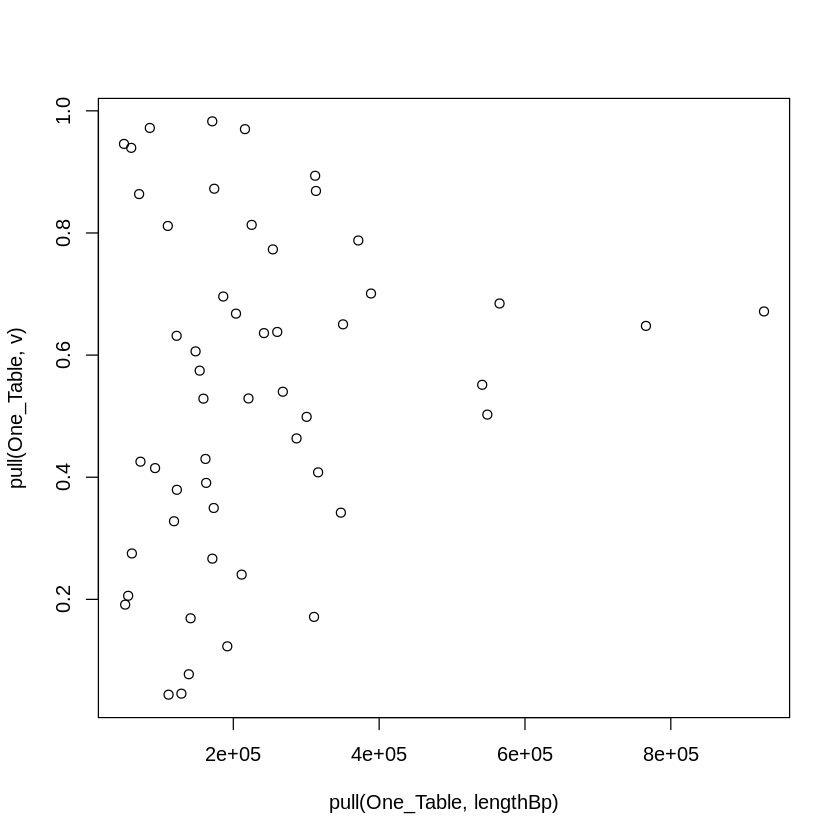

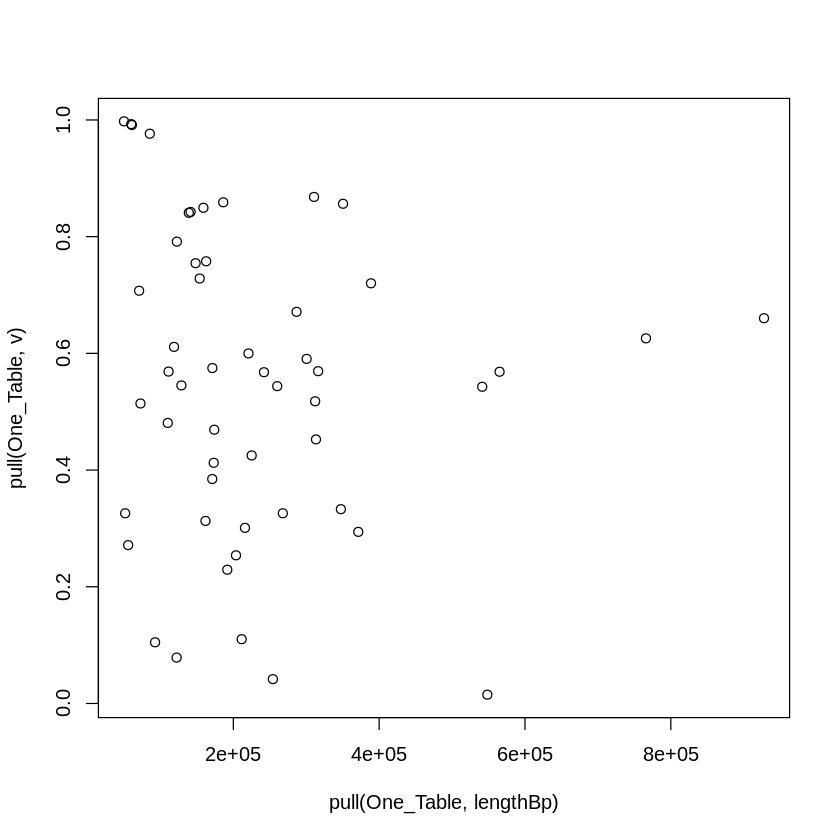

value,pAnova
<chr>,<dbl>
tree_changes_raw,1.556791e-11
PCA_eucldist_quantile_1,1.020975e-01
PCA_eucldist_quantile_2,2.571117e-01
IBS_eucldist_quantile_1,4.659357e-01
IBS_eucldist_quantile_2,6.001979e-01


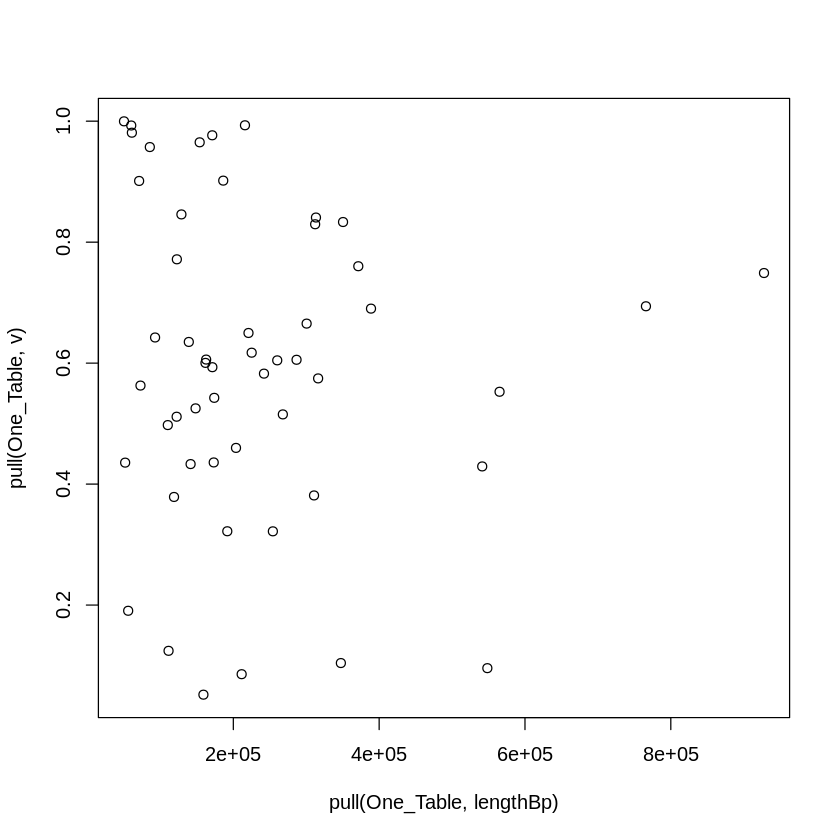

In [23]:
# the same is not the case for other local phylogeny measures
lp_bias<-data.table(value=c("tree_changes_raw","PCA_eucldist_quantile_1",
                           "PCA_eucldist_quantile_2","IBS_eucldist_quantile_1",
                           "IBS_eucldist_quantile_2"), pAnova=NA)
for(v in pull(lp_bias,value)){
    lp_bias<-mutate(lp_bias, pAnova=ifelse(value==v, anova(lm(pull(One_Table,v)~pull(One_Table, lengthBp)), lm(pull(One_Table,v)~1, One_Table))$`Pr(>F)`[2],pAnova))
    plot(pull(One_Table,v)~pull(One_Table, lengthBp))
}

lp_bias

In [24]:
options(repr.plot.width=10, repr.plot.height=10)

# LP data prep

library(stringr)
library(tidyverse)

LP_colnames=c("PCA_eucldist_quantile_1","PCA_eucldist_sd_multiplier_1","IBS_eucldist_quantile_1","IBS_eucldist_sd_multiplier_1","tree_changes_quantile","tree_changes_sd_multiplier","PCA_eucldist_quantile_2","PCA_eucldist_sd_multiplier_2","IBS_eucldist_quantile_2","IBS_eucldist_sd_multiplier_2")
#LP_colnames=LP_colnames[grepl("quant",LP_colnames,fixed=TRUE)]
LP_summary<-pivot_longer(One_Table%>%select(Distorter, strongest, all_of(LP_colnames)), cols = LP_colnames)
LP_summary <- LP_summary %>% mutate(Distorter = case_when(
  substr(name, nchar(name), nchar(name)) %in% c("1", "2") & 
    substr(name, nchar(name), nchar(name)) == Distorter ~ TRUE,
  substr(name, nchar(name), nchar(name)) %in% c("1", "2") ~ FALSE,
  TRUE ~ NA_real_
))
LP_summary <- LP_summary %>% mutate(name = str_remove(name, "_[12]$"))

LP_summary <- LP_summary %>% 
  group_by(name) %>% 
  mutate(value_normalized = ifelse(grepl("quant",name,fixed=TRUE),value-0.5,value)) %>% 
  ungroup()

Warning message:
"package 'stringr' was built under R version 4.1.3"
Warning message:
"package 'tidyverse' was built under R version 4.1.3"
-- Attaching packages ------------------------------------------------------------------------------------------------------------------------------------------------------ tidyverse 1.3.2 --
v tibble  3.1.8     v purrr   1.0.1
v tidyr   1.3.0     v dplyr   1.1.0
v readr   2.1.3     v forcats 1.0.0
Warning message:
"package 'tibble' was built under R version 4.1.3"
Warning message:
"package 'tidyr' was built under R version 4.1.3"
Warning message:
"package 'readr' was built under R version 4.1.3"
Warning message:
"package 'purrr' was built under R version 4.1.3"
Warning message:
"package 'dplyr' was built under R version 4.1.3"
Warning message:
"package 'forcats' was built under R version 4.1.3"
-- Conflicts ----------------------------------------------------------------------------------------------------------------------------------------------

Next I am showing that the IBS and PCA values are overall higher than from the expected value (0.5 / 0.0), but not by much and the SD data indicates this to be perhaps driven by a few extreme examples, promising potential for interpretation.

Whether the value is taken from distorter or disorted does not matter, however, indicating more general changes at the locus.

**tree data not yet interpreted due to unfinished fix**


	One Sample t-test

data:  filter(LP_summary, name == "IBS_eucldist_quantile") %>% pull(value)
t = 2.8188, df = 103, p-value = 0.005782
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5212197 0.6219603
sample estimates:
mean of x 
  0.57159 



	One Sample t-test

data:  filter(LP_summary, name == "PCA_eucldist_quantile") %>% pull(value)
t = 2.0827, df = 103, p-value = 0.03976
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5025507 0.6043130
sample estimates:
mean of x 
0.5534318 



	One Sample t-test

data:  filter(LP_summary, name == "IBS_eucldist_sd_multiplier") %>% pull(value)
t = 2.2244, df = 103, p-value = 0.0283
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.03118616 0.54411863
sample estimates:
mean of x 
0.2876524 



	One Sample t-test

data:  filter(LP_summary, name == "PCA_eucldist_sd_multiplier") %>% pull(value)
t = 1.1109, df = 103, p-value = 0.2692
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.08469111  0.30038380
sample estimates:
mean of x 
0.1078463 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "IBS_eucldist_quantile") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "IBS_eucldist_quantile") %>% pull(value)
t = 0.66056, df = 99.104, p-value = 0.5104
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.06741913  0.13471015
sample estimates:
mean of x mean of y 
0.5884128 0.5547673 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "PCA_eucldist_quantile") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "PCA_eucldist_quantile") %>% pull(value)
t = -0.11953, df = 101.83, p-value = 0.9051
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.10842969  0.09610378
sample estimates:
mean of x mean of y 
0.5503504 0.5565133 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "IBS_eucldist_sd_multiplier") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "IBS_eucldist_sd_multiplier") %>% pull(value)
t = 0.6004, df = 101.62, p-value = 0.5496
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.3588488  0.6703822
sample estimates:
mean of x mean of y 
0.3655357 0.2097691 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "PCA_eucldist_sd_multiplier") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "PCA_eucldist_sd_multiplier") %>% pull(value)
t = 0.15876, df = 97.561, p-value = 0.8742
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.3561955  0.4181378
sample estimates:
 mean of x  mean of y 
0.12333192 0.09236078 


name,mean
<chr>,<dbl>
IBS_eucldist_quantile,0.5715900
IBS_eucldist_sd_multiplier,0.2876524
PCA_eucldist_quantile,0.5534318
PCA_eucldist_sd_multiplier,0.1078463
tree_changes_quantile,0.0000000
tree_changes_sd_multiplier,-10.8864379


Distorter,strongest,name,value,value_normalized
<dbl>,<lgl>,<chr>,<dbl>,<dbl>
0,FALSE,PCA_eucldist_quantile,0.2951732,-0.2048268
0,FALSE,PCA_eucldist_sd_multiplier,-0.2505780,-0.2505780
0,FALSE,IBS_eucldist_quantile,0.7914947,0.2914947
0,FALSE,IBS_eucldist_sd_multiplier,0.1568852,0.1568852
NA,FALSE,tree_changes_quantile,0.0000000,-0.5000000
NA,FALSE,tree_changes_sd_multiplier,-10.7751836,-10.7751836


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


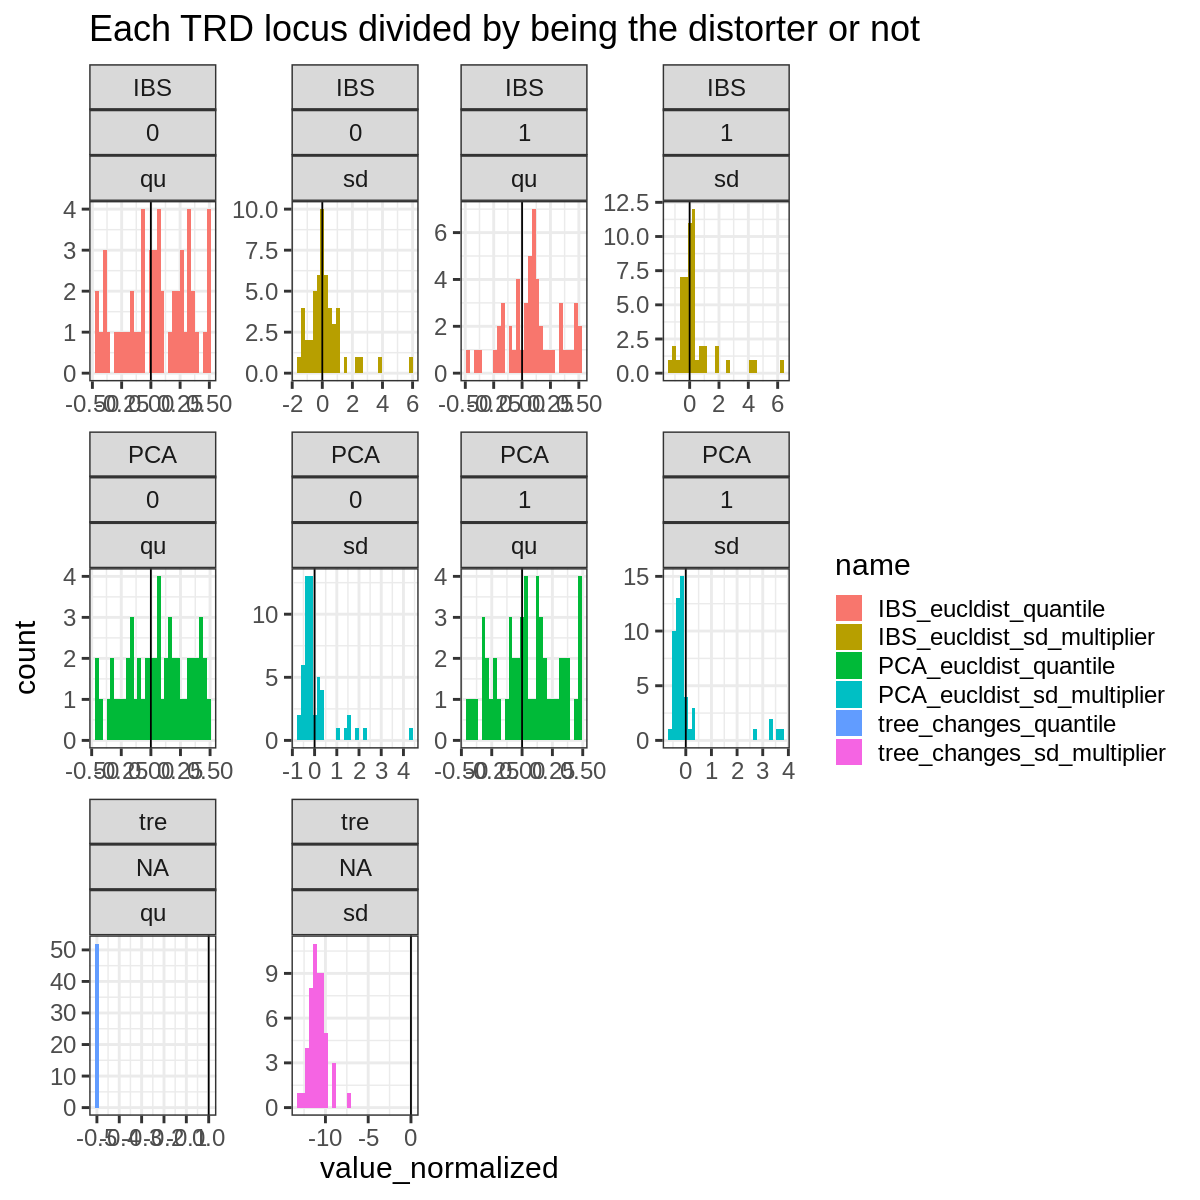

In [25]:
t.test(filter(LP_summary, name == "IBS_eucldist_quantile")%>%pull(value), mu=0.5)
t.test(filter(LP_summary, name == "PCA_eucldist_quantile")%>%pull(value), mu=0.5)
t.test(filter(LP_summary, name == "IBS_eucldist_sd_multiplier")%>%pull(value), mu=0)
t.test(filter(LP_summary, name == "PCA_eucldist_sd_multiplier")%>%pull(value), mu=0)

t.test(filter(LP_summary, Distorter==TRUE, name == "IBS_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "IBS_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)
t.test(filter(LP_summary, Distorter==TRUE, name == "PCA_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "PCA_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)
t.test(filter(LP_summary, Distorter==TRUE, name == "IBS_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "IBS_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)
t.test(filter(LP_summary, Distorter==TRUE, name == "PCA_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "PCA_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)

LP_summary%>%group_by(name)%>%summarize(mean=mean(value,na.rm=TRUE))

head(LP_summary)
ggplot(LP_summary, aes(value_normalized,fill=name))+
geom_histogram(position="dodge")+geom_vline(xintercept=0)+
facet_wrap(~substr(name,1,3)+Distorter+substr(name,14,15),scales="free")+theme_bw(18)+ggtitle("Each TRD locus divided by being the distorter or not")

In [26]:
# does not matter if we are looking at the strongest distorter

t.test(filter(LP_summary, Distorter==TRUE&strongest==TRUE, name == "IBS_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==TRUE&strongest==FALSE, name == "IBS_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==TRUE&strongest==TRUE, name == "PCA_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==TRUE&strongest==FALSE, name == "PCA_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==TRUE&strongest==TRUE, name == "IBS_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==TRUE&strongest==FALSE, name == "IBS_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==TRUE&strongest==TRUE, name == "PCA_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==TRUE&strongest==FALSE, name == "PCA_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==FALSE&strongest==TRUE, name == "IBS_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE&strongest==FALSE, name == "IBS_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==FALSE&strongest==TRUE, name == "PCA_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE&strongest==FALSE, name == "PCA_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==FALSE&strongest==TRUE, name == "IBS_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==FALSE&strongest==FALSE, name == "IBS_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==FALSE&strongest==TRUE, name == "PCA_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==FALSE&strongest==FALSE, name == "PCA_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

[1] 0.4720855

[1] 0.7769973

[1] 0.6847184

[1] 0.9961701

[1] 0.5011183

[1] 0.798939

[1] 0.3495414

[1] 0.7928528

In [27]:
# pixy data overview

pixy_files<-list.files("/home/jnrunge/data/trd/pop_genomics","relative-measures.RDS$",full.names = TRUE)
pixy_df<-data.table()
for(f in pixy_files){
    f_<-readRDS(f)


f_ <- lapply(f_, function(x) {
  if ("pi_pop" %in% names(x)) {
    names(x)[names(x) == "pi_pop"] <- "sum_value"
  }
  x
})

df <- f_ %>%
  purrr::imap_dfr(function(y, name) {
    data.table(analysis = name, t(y))
  })
    
    df<-mutate(df, file=basename(f))
    
    pixy_df<-bind_rows(pixy_df, df)
    
}
pixy_df<-mutate(pixy_df, ecdf_value=as.numeric(ecdf_value))
pixy_df<-mutate(pixy_df, standardized_measure=as.numeric(standardized_measure))
pixy_df<-mutate(pixy_df, sum_value=as.numeric(sum_value))
pixy_df_OG<-pixy_df
head(pixy_df)






analysis,sum_value,ecdf_value,standardized_measure,file
<chr>,<dbl>,<dbl>,<dbl>,<chr>
pi_distorter,0.0009943079,0.3612785,-0.08921610,ChrisC1.1-relative-measures.RDS
pi_other,0.0034313165,0.5492884,-0.06241907,ChrisC1.1-relative-measures.RDS
fst,0.1083332162,0.7935371,0.48939505,ChrisC1.1-relative-measures.RDS
dxy,0.0027576655,0.5276395,-0.06862047,ChrisC1.1-relative-measures.RDS
pi_distorter,0.0008429781,0.6485542,-0.03174992,ChrisC1.13-relative-measures.RDS
pi_other,0.0036112803,0.5879682,-0.05219997,ChrisC1.13-relative-measures.RDS


In [28]:
getCrossAndID=function(x){
    x<-strsplit(x, "-", fixed=TRUE)[[1]][1]
    x<-strsplit(x, ".", fixed=TRUE)[[1]]
    return(data.table(cross=x[1], ID=x[2]))
}

pixy_df<-bind_cols(pixy_df, bind_rows(lapply(pull(pixy_df, file), getCrossAndID)))
head(pixy_df)
pixy_df%>%pull(cross)%>%unique()

pixy_df<-select(pixy_df, -file)%>%
  pivot_wider(names_from = analysis, 
              values_from = c(sum_value, ecdf_value, standardized_measure),
              names_sep = "_",
              id_cols = c(cross, ID))


analysis,sum_value,ecdf_value,standardized_measure,file,cross,ID
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
pi_distorter,0.0009943079,0.3612785,-0.08921610,ChrisC1.1-relative-measures.RDS,ChrisC1,1
pi_other,0.0034313165,0.5492884,-0.06241907,ChrisC1.1-relative-measures.RDS,ChrisC1,1
fst,0.1083332162,0.7935371,0.48939505,ChrisC1.1-relative-measures.RDS,ChrisC1,1
dxy,0.0027576655,0.5276395,-0.06862047,ChrisC1.1-relative-measures.RDS,ChrisC1,1
pi_distorter,0.0008429781,0.6485542,-0.03174992,ChrisC1.13-relative-measures.RDS,ChrisC1,13
pi_other,0.0036112803,0.5879682,-0.05219997,ChrisC1.13-relative-measures.RDS,ChrisC1,13


[1] "ChrisC1" "ChrisC3" "ChrisC4" "ChrisC5" "ChrisC7" "ChrisC8" "YJNRC12"
 [8] "YJNRC14" "YJNRC15" "YJNRC18" "YJNRC19" "YJNRC2"  "YJNRC20" "YJNRC21"
[15] "YJNRC22" "YJNRC23" "YJNRC24" "YJNRC25" "YJNRC26" "YJNRC27" "YJNRC29"
[22] "YJNRC3"  "YJNRC30" "YJNRC31" "YJNRC32" "YJNRC4"  "YJNRC5"  "YJNRC6" 
[29] "YJNRC7"  "YJNRC8"  "YJNRC9"

In [29]:
pixy_df<-mutate(pixy_df, ID=as.numeric(ID))
One_Table<-full_join(One_Table, pixy_df, by=c("cross","ID"))

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 920 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 920 rows containing missing values (`geom_point()`)."


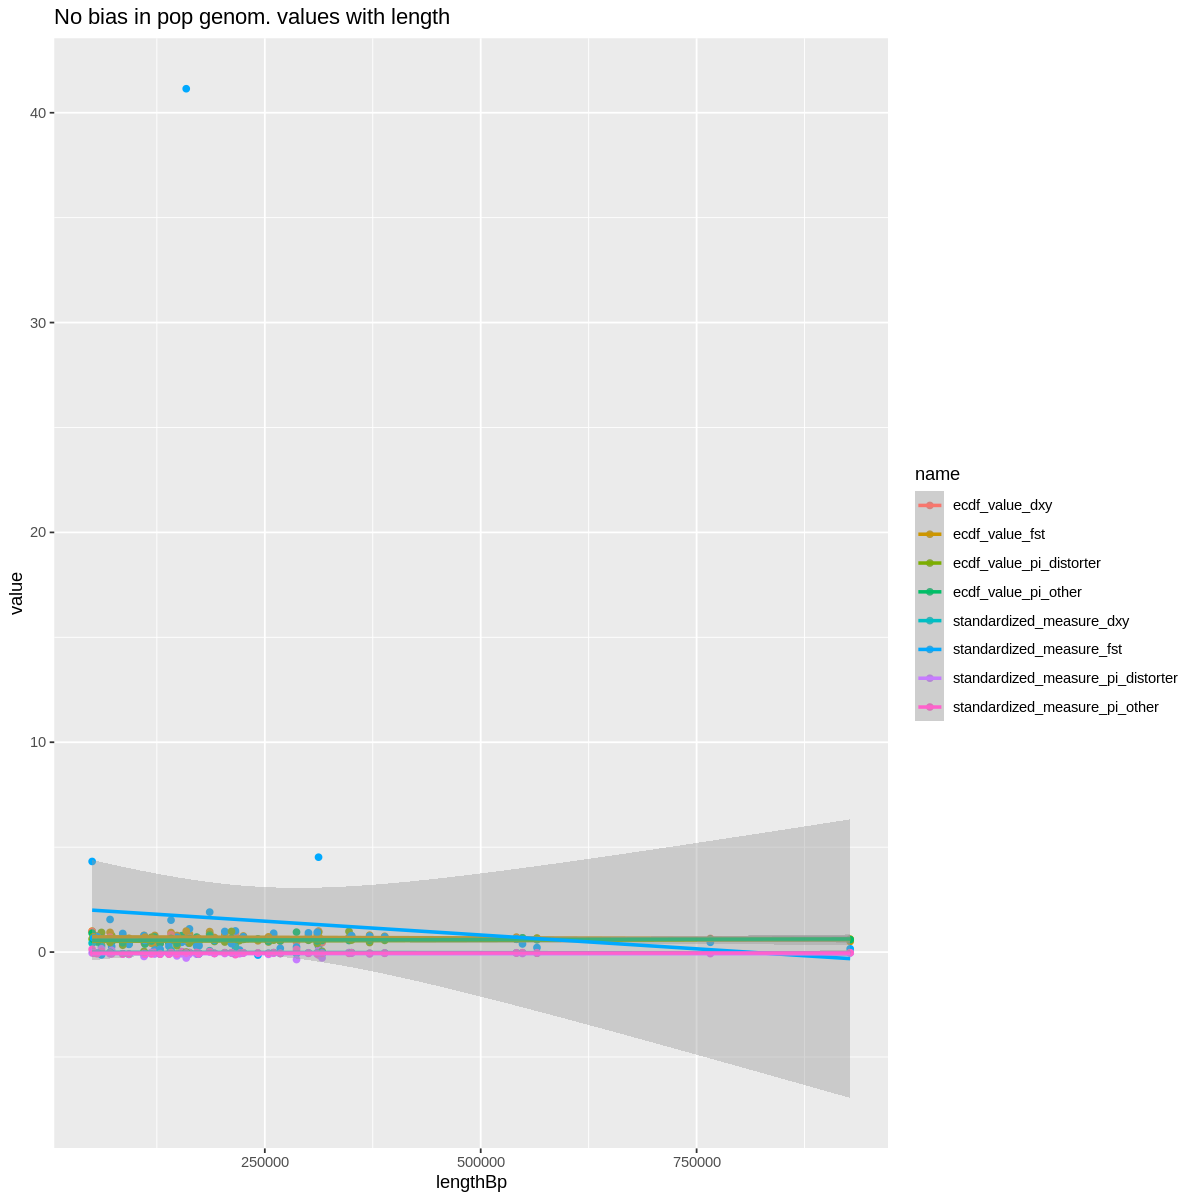

In [30]:
ggplot(One_Table%>%select(cross,ID,ecdf_value_fst,ecdf_value_dxy,ecdf_value_pi_distorter,ecdf_value_pi_other,standardized_measure_fst,standardized_measure_dxy,standardized_measure_pi_distorter,standardized_measure_pi_other,lengthBp)%>%
pivot_longer(cols = c(ecdf_value_fst, ecdf_value_dxy, ecdf_value_pi_distorter, 
                        ecdf_value_pi_other, standardized_measure_fst, standardized_measure_dxy, 
                        standardized_measure_pi_distorter, standardized_measure_pi_other)),
       aes(lengthBp, value, color=name))+
geom_point()+geom_smooth(method="lm")+ggtitle("No bias in pop genom. values with length")

evidence that fst is increased at trd loci, but mixed results for other values; probably more interesting to look at specific examples

In [31]:
pixy_global_tests<-data.table(value=c("ecdf_value_fst","ecdf_value_dxy","ecdf_value_pi_distorter","ecdf_value_pi_other","standardized_measure_fst","standardized_measure_dxy","standardized_measure_pi_distorter","standardized_measure_pi_other"),
                             p=NA, mean=NA)
for(i in 1:nrow(pixy_global_tests)){
    pgt_slice<-slice(pixy_global_tests, i)
    pgt_slice_value<-pull(pgt_slice, value)
    ttest_value<-t.test(pull(One_Table, pgt_slice_value), mu=ifelse(startsWith(pgt_slice_value,"ecdf"),0.5,0))$p.value
    pixy_global_tests<-mutate(pixy_global_tests, p=ifelse(value==pgt_slice_value,ttest_value,p))
    pixy_global_tests<-mutate(pixy_global_tests, mean=ifelse(value==pgt_slice_value,mean(pull(One_Table, pgt_slice_value),na.rm=TRUE),mean))
}
pixy_global_tests

value,p,mean
<chr>,<dbl>,<dbl>
ecdf_value_fst,3.907424e-31,0.691333834
ecdf_value_dxy,1.647378e-18,0.614213695
ecdf_value_pi_distorter,7.101947e-01,0.505686697
ecdf_value_pi_other,4.166233e-12,0.581588947
standardized_measure_fst,5.747324e-04,0.886041514
standardized_measure_dxy,5.503592e-01,-0.009032854
standardized_measure_pi_distorter,3.901966e-29,-0.072059175
standardized_measure_pi_other,7.379714e-23,-0.051927392


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 54 rows containing non-finite values (`stat_bin()`)."


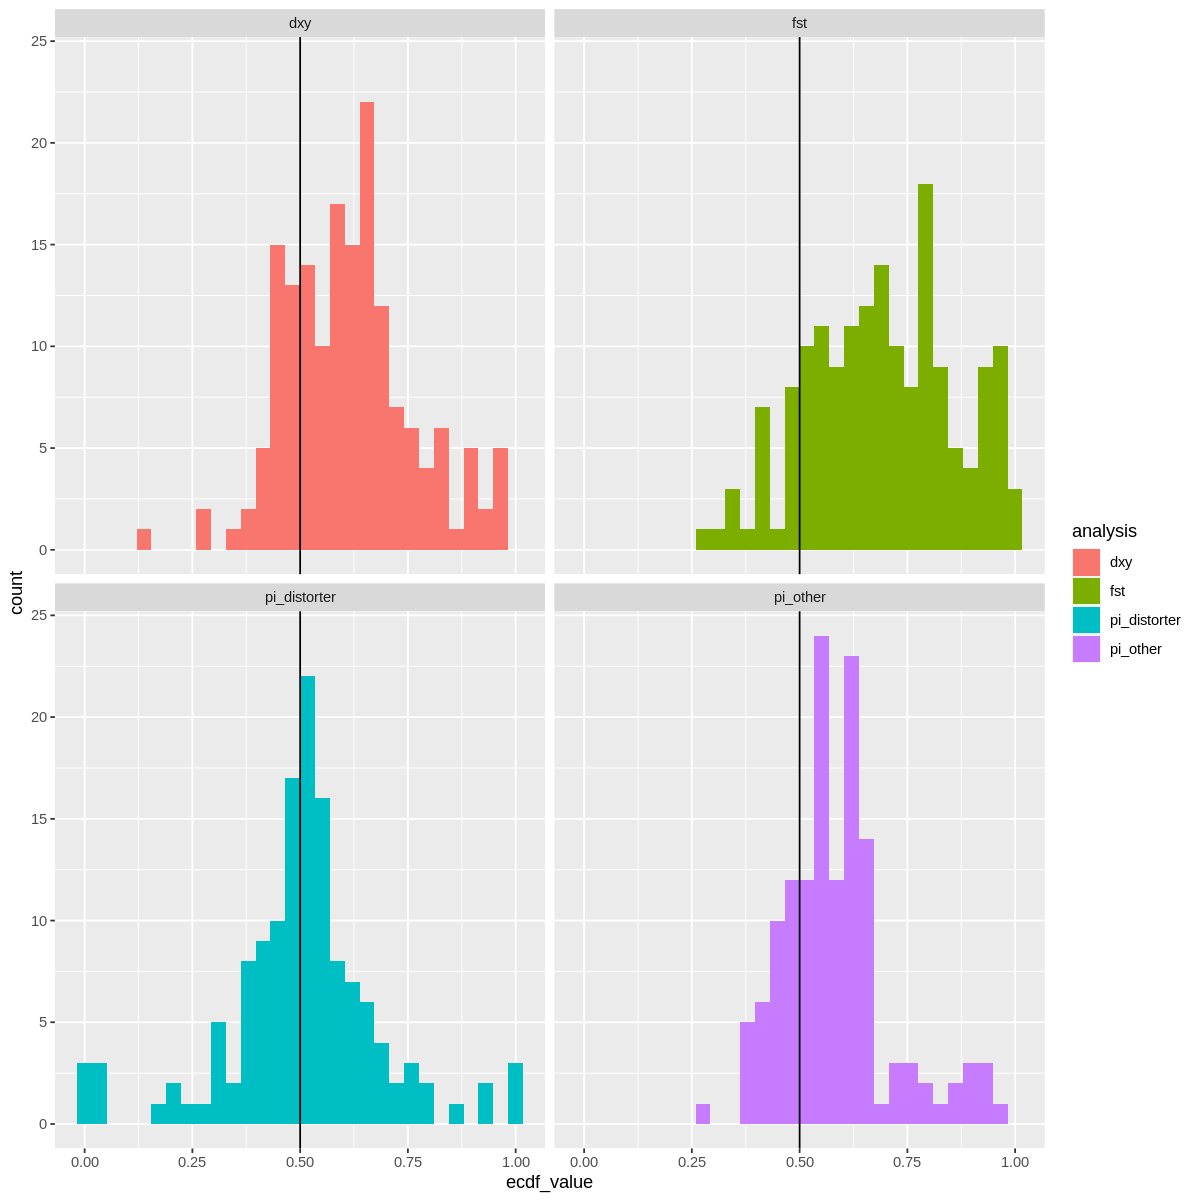

In [32]:
ggplot(pixy_df_OG, aes(ecdf_value, fill=analysis))+
geom_histogram()+facet_wrap(~analysis)+geom_vline(xintercept = 0.5)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 54 rows containing non-finite values (`stat_bin()`)."


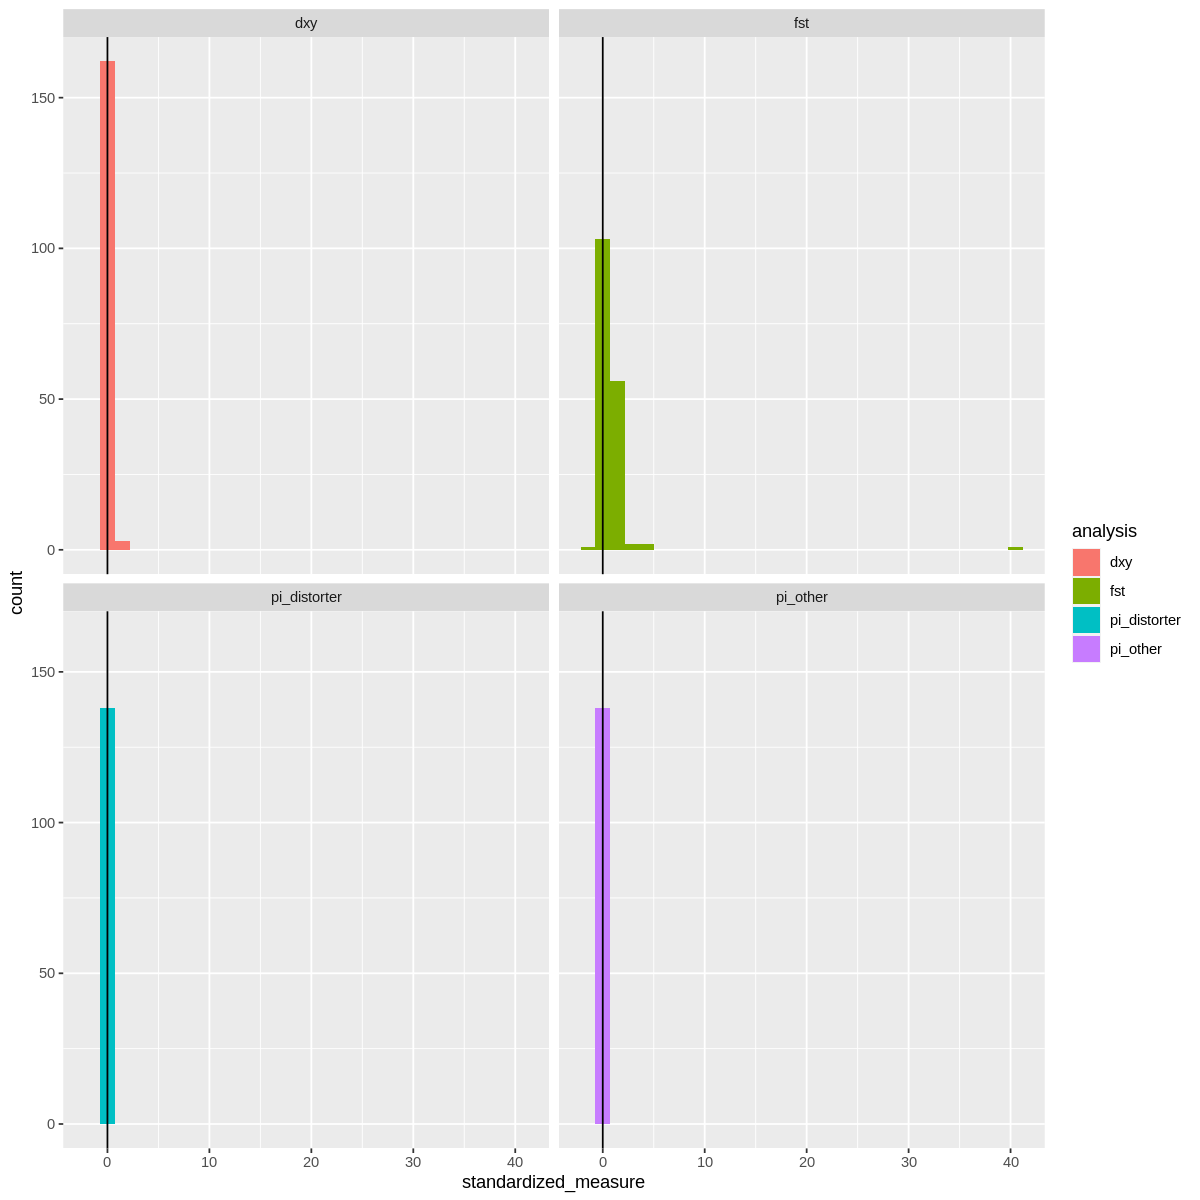

In [33]:
ggplot(pixy_df_OG, aes(standardized_measure, fill=analysis))+
geom_histogram()+facet_wrap(~analysis)+geom_vline(xintercept = 0)

In [34]:
colnames(One_Table)

[1] "ID"                                "lengthSNPs"                       
 [3] "chr"                               "global_start"                     
 [5] "global_end"                        "lengthBp"                         
 [7] "cross"                             "start"                            
 [9] "end"                               "PCA_eucldist_quantile_1"          
[11] "PCA_eucldist_sd_multiplier_1"      "IBS_eucldist_quantile_1"          
[13] "IBS_eucldist_sd_multiplier_1"      "tree_changes_quantile"            
[15] "tree_changes_sd_multiplier"        "tree_changes_raw"                 
[17] "PCA_eucldist_quantile_2"           "PCA_eucldist_sd_multiplier_2"     
[19] "IBS_eucldist_quantile_2"           "IBS_eucldist_sd_multiplier_2"     
[21] "AF"                                "AF_lm_int"                        
[23] "AF_lm_poly1"                       "AF_lm_poly2"                      
[25] "AF_lm_r2"                          "AF_lm_anova"                      
[27] "AF_lm_anova_RSS"                   "AF_lm_poly1_1"                    
[29] "AF_lm_resid_median"                "Distorter"                        
[31] "polynomial_filtered_out"           "bad_viz_inf"                      
[33] "strongest"                         "sum_value_pi_distorter"           
[35] "sum_value_pi_other"                "sum_value_fst"                    
[37] "sum_value_dxy"                     "ecdf_value_pi_distorter"          
[39] "ecdf_value_pi_other"               "ecdf_value_fst"                   
[41] "ecdf_value_dxy"                    "standardized_measure_pi_distorter"
[43] "standardized_measure_pi_other"     "standardized_measure_fst"         
[45] "standardized_measure_dxy"

In [35]:
# add SV data to big table#
One_Table<-One_Table%>%mutate(ID=as.character(ID))
One_Table<-left_join(One_Table,pivot_wider(SV_data_summary_parent_v_parent, id_cols=c("cross","ID"), names_from=c("TYPE"), values_from = c("LEN_rel_diff_abs"), values_fill = 0), by=c("cross","ID"))
One_Table

ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,PCA_eucldist_quantile_1,...,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,CONTR,DEL,DUP,INS,INV,TRA
<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,155,chromosome2,668344,790905,122561,ChrisC1,444778,567339,0.29517316,...,-0.08921610,-0.062419070,0.48939505,-0.06862047,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.0000000
13,815,chromosome15,10015850,10580994,565144,ChrisC1,66814,631958,0.65739578,...,-0.03174992,-0.052199966,0.21550380,-0.05009059,0.000000e+00,0.000000e+00,0.000000e+00,2.831137e-05,0,0.0000000
14,235,chromosome16,11462227,11683028,220801,ChrisC1,429498,650299,0.47568634,...,-0.07926234,-0.042589452,0.09760369,-0.05530807,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.0000000
4,2603,chromosome5,2944974,3258307,313333,ChrisC3,65081,378414,0.71577247,...,-0.07635785,-0.061159202,0.51830964,-0.06260074,0.000000e+00,1.184044e-03,0.000000e+00,3.102131e-03,0,0.0000000
11,901,chromosome11,6549018,6720267,171249,ChrisC3,18001,189250,0.15993780,...,-0.05552352,-0.092672270,0.29004999,-0.07721326,0.000000e+00,0.000000e+00,1.851106e-03,0.000000e+00,0,0.0000000
2,137,chromosome4,1633021,1919730,286709,ChrisC5,304176,590885,0.74902805,...,-0.35726161,0.126157502,0.24140746,-0.08008779,2.092714e-05,3.006882e-02,0.000000e+00,1.695099e-03,0,0.0000000
3,3567,chromosome5,2975476,3287692,312216,ChrisC7,96134,408350,0.39296609,...,0.09412889,-0.139754239,4.52148000,0.34367463,0.000000e+00,2.242038e-03,2.306096e-04,1.441310e-04,0,0.0000000
4,6799,chromosome7,3915832,4681735,765903,ChrisC7,204825,970728,0.51516239,...,-0.07438899,-0.045772699,0.46429916,0.01115319,3.394686e-05,5.003245e-03,2.232659e-04,8.208611e-03,0,0.0000000
7,1227,chromosome11,6558616,6697564,138948,ChrisC7,29994,168942,0.73790298,...,-0.06977052,-0.099646934,0.27885234,-0.08567111,0.000000e+00,1.029162e-03,3.375363e-03,2.303020e-04,0,0.0000000


In [38]:
One_Table<-filter(One_Table, !is.na(chr))

In [39]:
# add LD and TD data
LD_data<-fread("/home/jnrunge/data/trd/LD_data/LD_plot_data.csv.gz")
TD_data<-fread("/home/jnrunge/data/trd/TD_data/TD_plot_data.csv.gz")
One_Table<-One_Table%>%mutate(ID=as.numeric(ID))

One_Table<-left_join(One_Table, LD_data)
One_Table<-left_join(One_Table, TD_data)

Joining with `by = join_by(ID, cross)`
Joining with `by = join_by(ID, cross)`


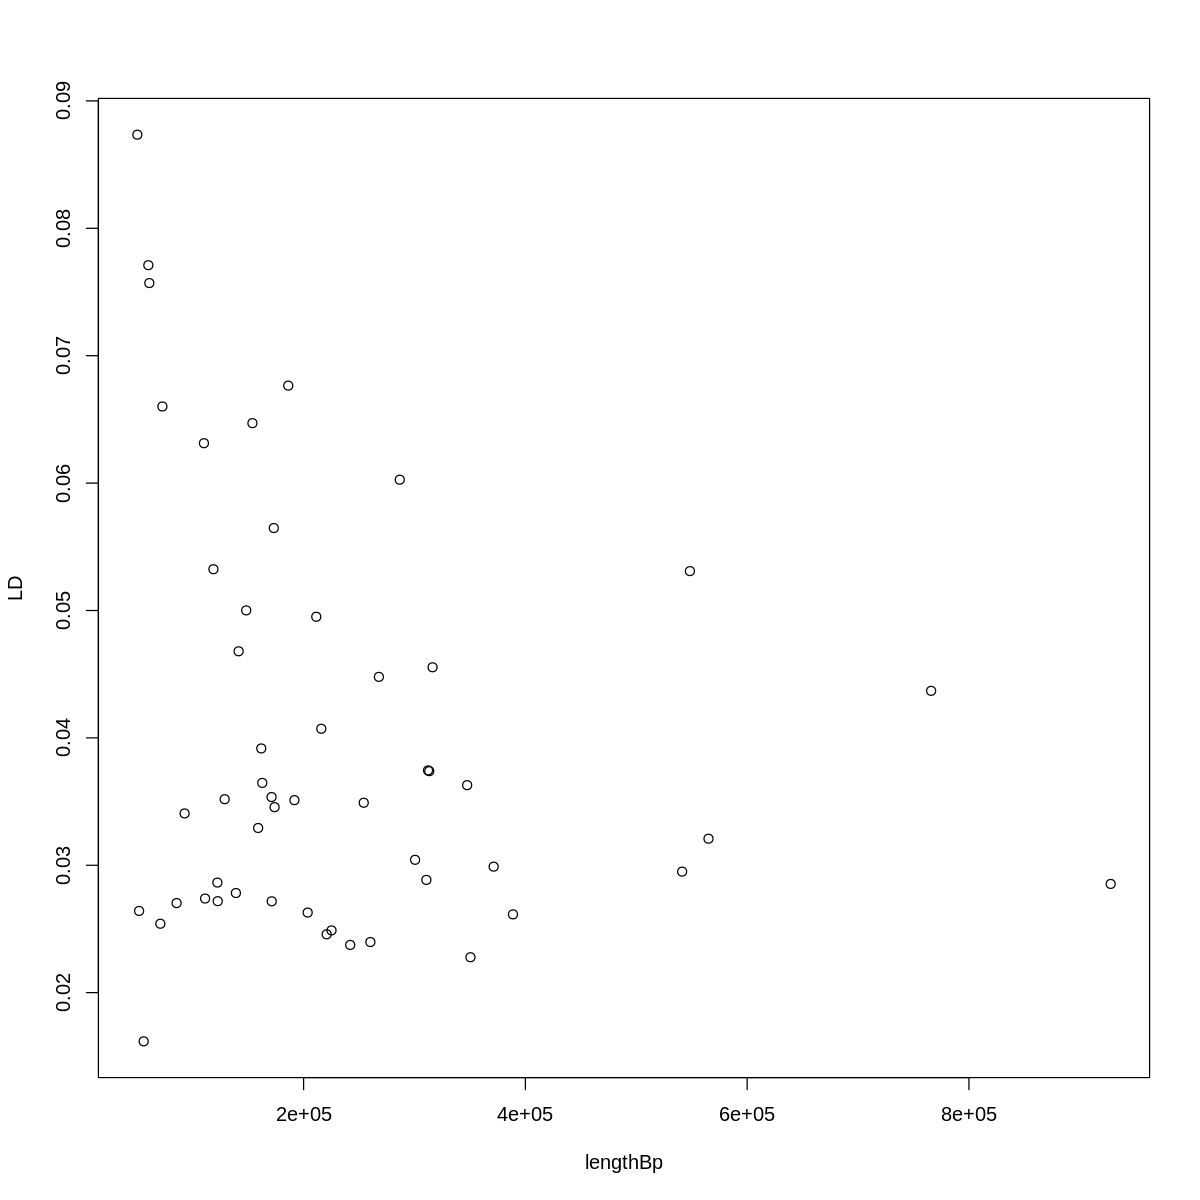

In [40]:
plot(LD ~ lengthBp, One_Table)

In [41]:
paste(colnames(One_Table),collapse=",")

[1] "ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,PCA_eucldist_quantile_1,PCA_eucldist_sd_multiplier_1,IBS_eucldist_quantile_1,IBS_eucldist_sd_multiplier_1,tree_changes_quantile,tree_changes_sd_multiplier,tree_changes_raw,PCA_eucldist_quantile_2,PCA_eucldist_sd_multiplier_2,IBS_eucldist_quantile_2,IBS_eucldist_sd_multiplier_2,AF,AF_lm_int,AF_lm_poly1,AF_lm_poly2,AF_lm_r2,AF_lm_anova,AF_lm_anova_RSS,AF_lm_poly1_1,AF_lm_resid_median,Distorter,polynomial_filtered_out,bad_viz_inf,strongest,sum_value_pi_distorter,sum_value_pi_other,sum_value_fst,sum_value_dxy,ecdf_value_pi_distorter,ecdf_value_pi_other,ecdf_value_fst,ecdf_value_dxy,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,CONTR,DEL,DUP,INS,INV,TRA,LD,LD_sd_multi_1,LD_sd_multi_2,TD,TD_sd_multi,TD_ecdf"

In [42]:
scale_numeric<-function(x){
    return(as.numeric(scale(x, center = FALSE)))
}

In [43]:
colnames(One_Table)

[1] "ID"                                "lengthSNPs"                       
 [3] "chr"                               "global_start"                     
 [5] "global_end"                        "lengthBp"                         
 [7] "cross"                             "start"                            
 [9] "end"                               "PCA_eucldist_quantile_1"          
[11] "PCA_eucldist_sd_multiplier_1"      "IBS_eucldist_quantile_1"          
[13] "IBS_eucldist_sd_multiplier_1"      "tree_changes_quantile"            
[15] "tree_changes_sd_multiplier"        "tree_changes_raw"                 
[17] "PCA_eucldist_quantile_2"           "PCA_eucldist_sd_multiplier_2"     
[19] "IBS_eucldist_quantile_2"           "IBS_eucldist_sd_multiplier_2"     
[21] "AF"                                "AF_lm_int"                        
[23] "AF_lm_poly1"                       "AF_lm_poly2"                      
[25] "AF_lm_r2"                          "AF_lm_anova"                      
[27] "AF_lm_anova_RSS"                   "AF_lm_poly1_1"                    
[29] "AF_lm_resid_median"                "Distorter"                        
[31] "polynomial_filtered_out"           "bad_viz_inf"                      
[33] "strongest"                         "sum_value_pi_distorter"           
[35] "sum_value_pi_other"                "sum_value_fst"                    
[37] "sum_value_dxy"                     "ecdf_value_pi_distorter"          
[39] "ecdf_value_pi_other"               "ecdf_value_fst"                   
[41] "ecdf_value_dxy"                    "standardized_measure_pi_distorter"
[43] "standardized_measure_pi_other"     "standardized_measure_fst"         
[45] "standardized_measure_dxy"          "CONTR"                            
[47] "DEL"                               "DUP"                              
[49] "INS"                               "INV"                              
[51] "TRA"                               "LD"                               
[53] "LD_sd_multi_1"                     "LD_sd_multi_2"                    
[55] "TD"                                "TD_sd_multi"                      
[57] "TD_ecdf"

In [44]:
summarize(group_by(One_Table, Distorter), n=n())

Distorter,n
<chr>,<int>
1,25
2,27


In [45]:
# acknowldgeding TRD direction in the PCA / IBS data

One_Table<-mutate(One_Table, PCA_eucldist_sd_multiplier_distorter=ifelse(Distorter==1,
                                                                         PCA_eucldist_sd_multiplier_1,
                                                                         PCA_eucldist_sd_multiplier_2),
                    PCA_eucldist_sd_multiplier_other=ifelse(Distorter==2,
                                                                         PCA_eucldist_sd_multiplier_1,
                                                                         PCA_eucldist_sd_multiplier_2),
                 IBS_eucldist_sd_multiplier_distorter=ifelse(Distorter==1,
                                                                         IBS_eucldist_sd_multiplier_1,
                                                                         IBS_eucldist_sd_multiplier_2),
                 IBS_eucldist_sd_multiplier_other=ifelse(Distorter==2,
                                                                         IBS_eucldist_sd_multiplier_1,
                                                                         IBS_eucldist_sd_multiplier_2))

name,mean,ttest_p_value
<chr>,<dbl>,<dbl>
IBS_eucldist_sd_multiplier_distorter,0.36553574,5.865177e-02
IBS_eucldist_sd_multiplier_other,0.20976905,2.433877e-01
LD_sd_multi_1,2.56495073,4.739848e-22
LD_sd_multi_2,-0.93950236,1.689429e-12
PCA_eucldist_sd_multiplier_distorter,0.12333192,4.207553e-01
PCA_eucldist_sd_multiplier_other,0.09236078,4.538038e-01
TD_sd_multi,0.22309548,1.353164e-01
standardized_measure_dxy,-0.01817466,2.381609e-01
standardized_measure_fst,1.50317107,6.673441e-02


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


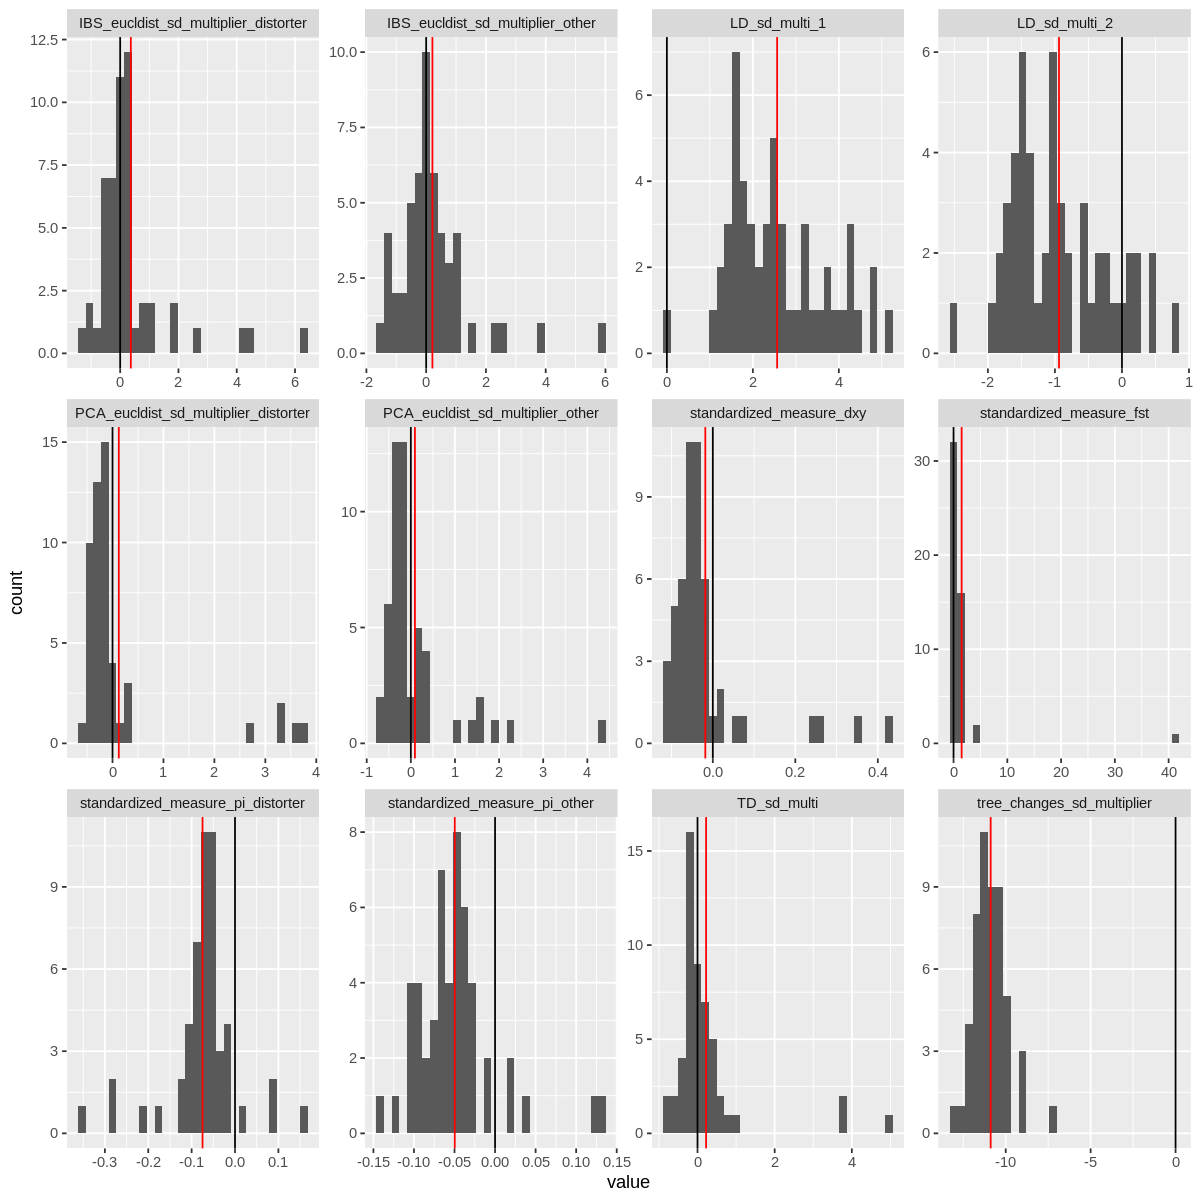

In [46]:
# is the mean different from expectation?

One_Table_sd_based_values<-One_Table%>%select(matches("sd|standardized"))%>%select(!matches("multiplier_[12]"))%>%
pivot_longer(cols=everything())%>%filter(!is.na(value))

One_Table_sd_based_values_means<-One_Table_sd_based_values%>%group_by(name)%>%summarize(mean=mean(value),
                                                                                       ttest_p_value=t.test(value,
                                                                                                           mu=0)$p.value)
One_Table_sd_based_values_means
ggplot(One_Table_sd_based_values,
      aes(value))+
geom_histogram()+facet_wrap(~name, scales="free")+geom_vline(xintercept=0)+
geom_vline(data=One_Table_sd_based_values_means, aes(xintercept=mean), color="red")



In [47]:
knitr::kable(One_Table_sd_based_values_means)



|name                                 |        mean| ttest_p_value|
|:------------------------------------|-----------:|-------------:|
|IBS_eucldist_sd_multiplier_distorter |   0.3655357|     0.0586518|
|IBS_eucldist_sd_multiplier_other     |   0.2097691|     0.2433877|
|LD_sd_multi_1                        |   2.5649507|     0.0000000|
|LD_sd_multi_2                        |  -0.9395024|     0.0000000|
|PCA_eucldist_sd_multiplier_distorter |   0.1233319|     0.4207553|
|PCA_eucldist_sd_multiplier_other     |   0.0923608|     0.4538038|
|TD_sd_multi                          |   0.2230955|     0.1353164|
|standardized_measure_dxy             |  -0.0181747|     0.2381609|
|standardized_measure_fst             |   1.5031711|     0.0667344|
|standardized_measure_pi_distorter    |  -0.0748616|     0.0000000|
|standardized_measure_pi_other        |  -0.0497113|     0.0000000|
|tree_changes_sd_multiplier           | -10.8864379|     0.0000000|

In [48]:
# getting rid of the SVs and also NAs
# only one type of variable (sd multipliers) for now so that no scaling issues can arise
clustering_subset<-select(One_Table, AF,
                         PCA_eucldist_sd_multiplier_distorter,IBS_eucldist_sd_multiplier_distorter,
                          #tree_changes_quantile,tree_changes_sd_multiplier,tree_changes_raw,
                        PCA_eucldist_sd_multiplier_other,IBS_eucldist_sd_multiplier_other,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,LD_sd_multi_2,TD_sd_multi)


clustering_subset <- clustering_subset %>% mutate(AF=abs(AF-0.5)) %>%
  # Scale all columns
  mutate_all(~ scale_numeric(.)) %>% mutate(row=row_number())%>%
  # Convert to rowwise data frame
  rowwise() %>%
  # Remove rows with NA values
  filter(!any(is.na(c_across(everything()))))

OneTable_rows_in_clustering_subset<-pull(clustering_subset, row)
clustering_subset<-select(clustering_subset, -row)

In [49]:
clustering_subset%>%cor()

,AF,PCA_eucldist_sd_multiplier_distorter,IBS_eucldist_sd_multiplier_distorter,PCA_eucldist_sd_multiplier_other,IBS_eucldist_sd_multiplier_other,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,LD_sd_multi_2,TD_sd_multi
AF,1.00000000,-0.23247837,-0.2378181,-0.090732338,-0.03859483,-0.21281743,0.123919332,-0.11903483,-0.03201923,0.06756408,-0.15423333
PCA_eucldist_sd_multiplier_distorter,-0.23247837,1.00000000,0.7816638,0.688864214,0.47493225,0.18585268,0.361691156,0.02355975,0.36619255,0.25562341,0.70048135
IBS_eucldist_sd_multiplier_distorter,-0.23781811,0.78166381,1.0000000,0.432536391,0.68214287,0.16788789,0.576761807,0.11337720,0.59065233,0.40571588,0.88593703
PCA_eucldist_sd_multiplier_other,-0.09073234,0.68886421,0.4325364,1.000000000,0.50904830,0.08057730,0.001736552,0.01692405,0.27177273,0.01668245,0.32947948
IBS_eucldist_sd_multiplier_other,-0.03859483,0.47493225,0.6821429,0.509048302,1.00000000,0.14753943,0.363865317,-0.09196507,0.65522714,0.30659568,0.70122180
standardized_measure_pi_distorter,-0.21281743,0.18585268,0.1678879,0.080577302,0.14753943,1.00000000,-0.109684505,-0.32505686,0.46479671,0.01856729,0.23875184
standardized_measure_pi_other,0.12391933,0.36169116,0.5767618,0.001736552,0.36386532,-0.10968451,1.000000000,0.03938881,0.32605066,0.41488517,0.65627570
standardized_measure_fst,-0.11903483,0.02355975,0.1133772,0.016924053,-0.09196507,-0.32505686,0.039388809,1.00000000,0.06978197,-0.01226888,0.08332773
standardized_measure_dxy,-0.03201923,0.36619255,0.5906523,0.271772731,0.65522714,0.46479671,0.326050659,0.06978197,1.00000000,0.37279926,0.62294291
LD_sd_multi_2,0.06756408,0.25562341,0.4057159,0.016682454,0.30659568,0.01856729,0.414885174,-0.01226888,0.37279926,1.00000000,0.44984389


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


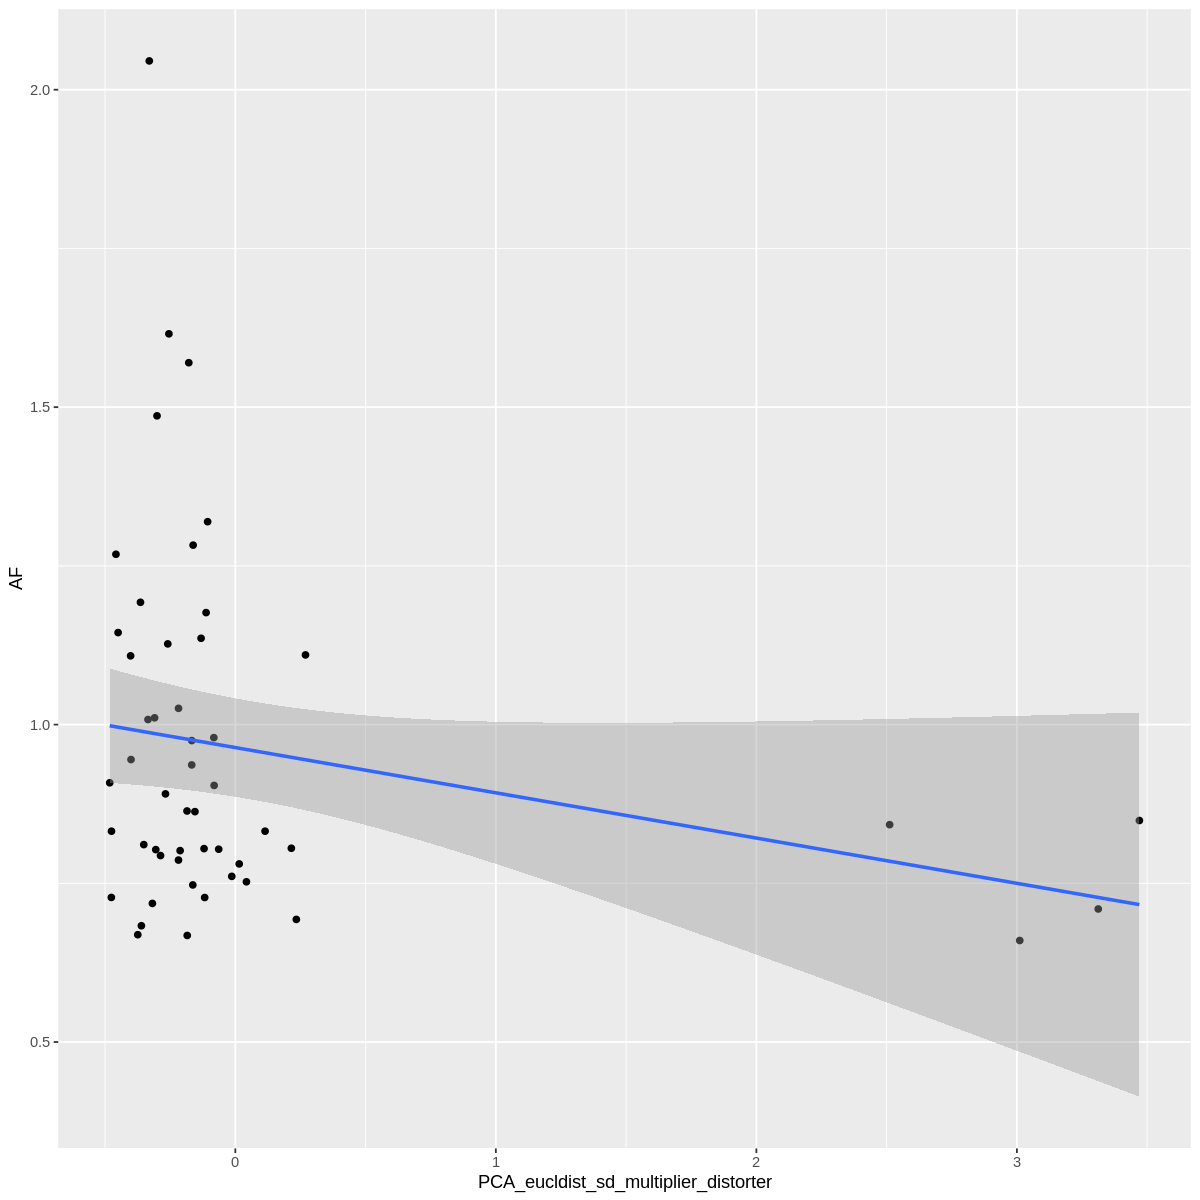

`geom_smooth()` using formula = 'y ~ x'


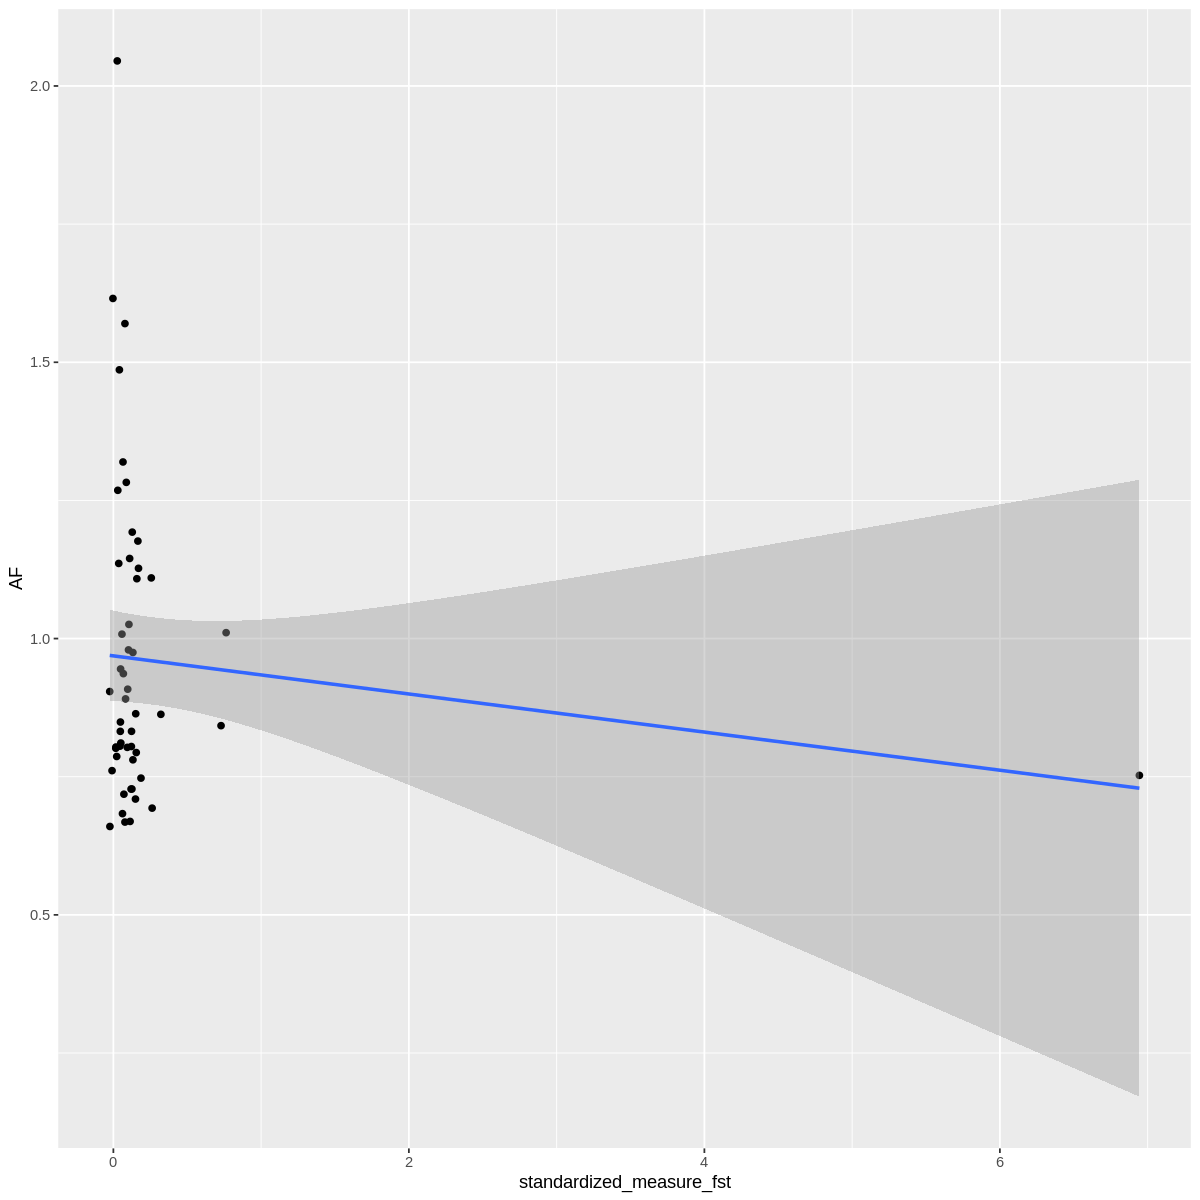

`geom_smooth()` using formula = 'y ~ x'


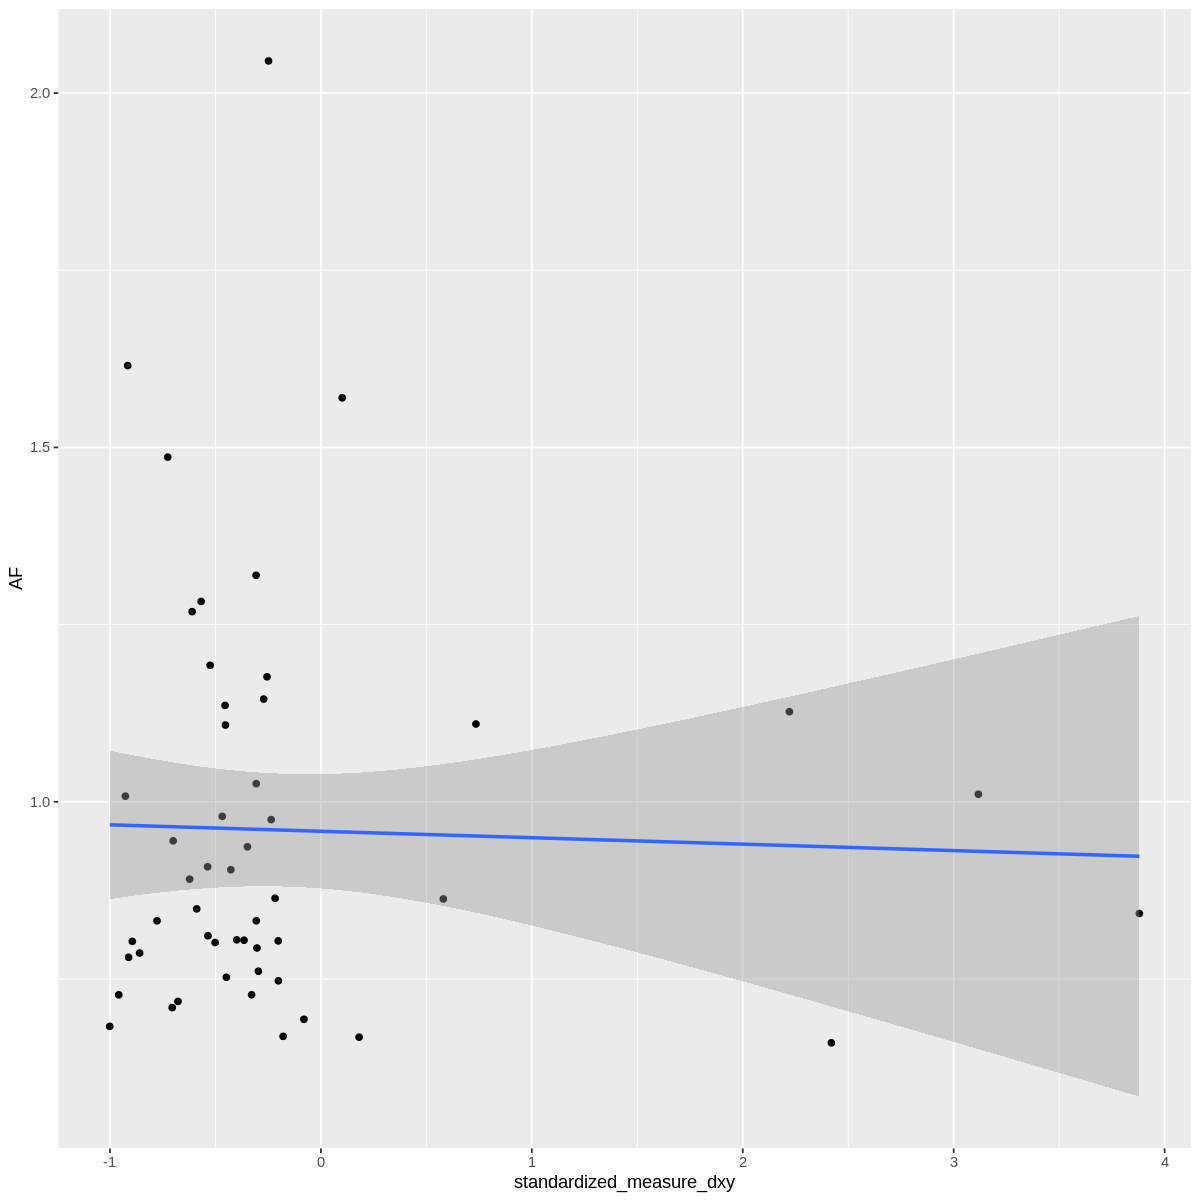

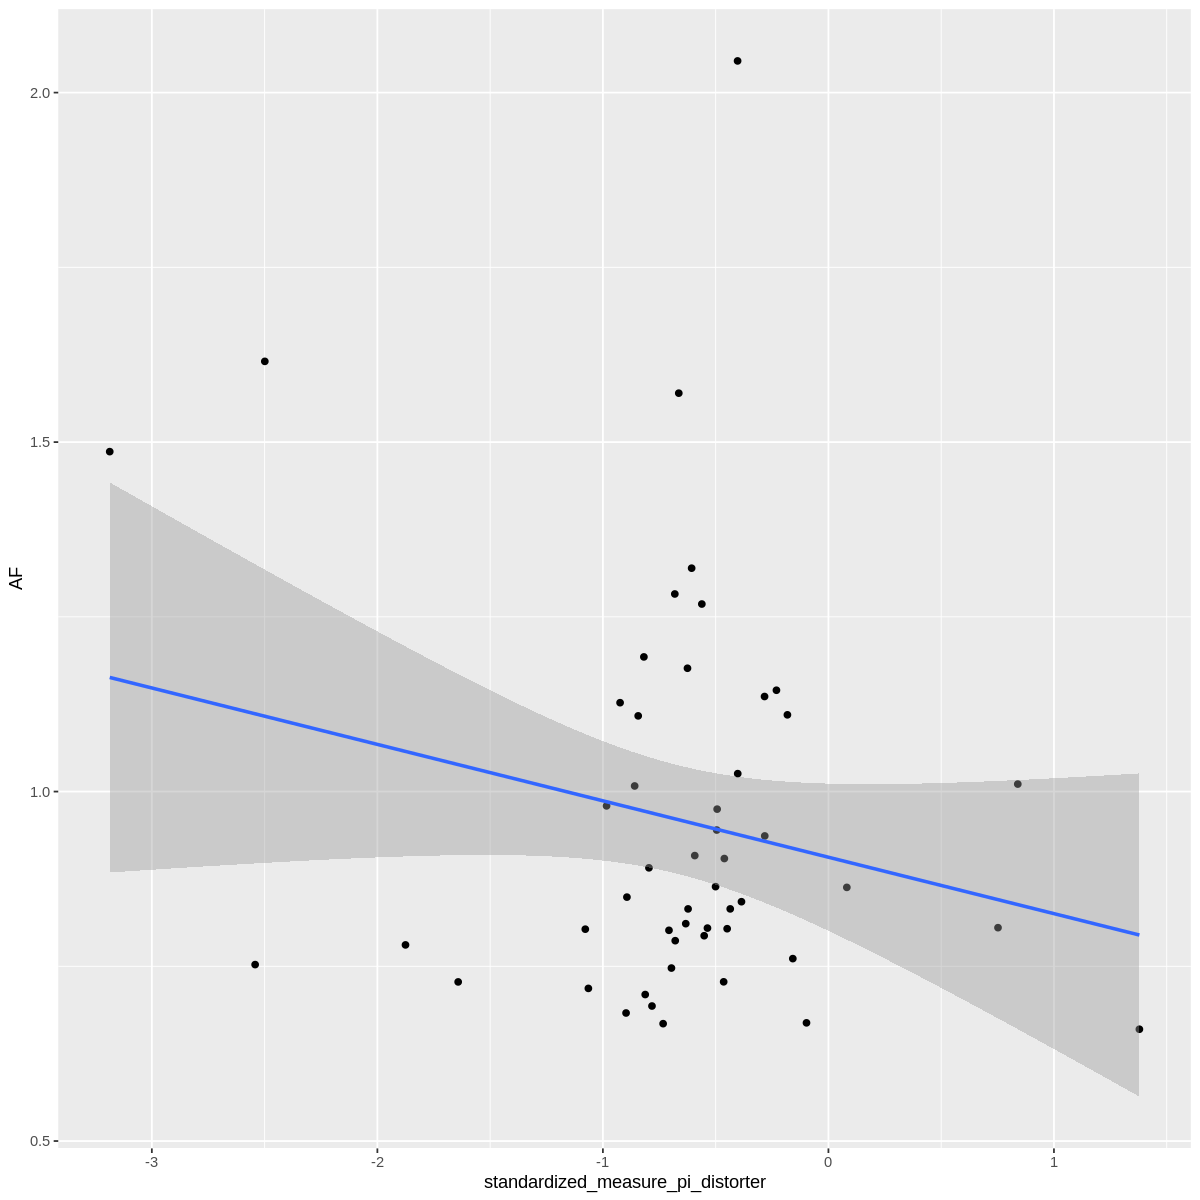

In [50]:
ggplot(clustering_subset, aes(PCA_eucldist_sd_multiplier_distorter, AF))+
geom_point()+geom_smooth(method="lm")

ggplot(clustering_subset, aes(standardized_measure_fst, AF))+
geom_point()+geom_smooth(method="lm")

ggplot(clustering_subset, aes(standardized_measure_dxy, AF))+
geom_point()+geom_smooth(method="lm")

ggplot(clustering_subset, aes(standardized_measure_pi_distorter, AF))+
geom_point()+geom_smooth(method="lm")

In [51]:


classify_values=function(x){
    # to group the TRD regions, I am classifying them by whether they are average or strong
    if(x >= 1){
        return("high")
    }
    if(x <= -1){
        return("weak")
    }
    return("average")
}
l_classify_values=function(x){
    return(unlist(lapply(x, classify_values)))
}

clustering_subset%>%
mutate_all(~ l_classify_values(.))%>%
group_by_all()%>%summarize(n=n())%>%arrange(-n)

`summarise()` has grouped output by 'AF', 'PCA_eucldist_sd_multiplier_distorter', 'IBS_eucldist_sd_multiplier_distorter', 'PCA_eucldist_sd_multiplier_other',
'IBS_eucldist_sd_multiplier_other', 'standardized_measure_pi_distorter', 'standardized_measure_pi_other', 'standardized_measure_fst', 'standardized_measure_dxy', 'LD_sd_multi_2'. You can
override using the `.groups` argument.


AF,PCA_eucldist_sd_multiplier_distorter,IBS_eucldist_sd_multiplier_distorter,PCA_eucldist_sd_multiplier_other,IBS_eucldist_sd_multiplier_other,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,LD_sd_multi_2,TD_sd_multi,n
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
average,average,average,average,average,average,average,average,average,weak,average,10
high,average,average,average,average,average,average,average,average,weak,average,6
average,average,average,average,average,average,average,average,average,average,average,4
average,average,average,average,average,average,weak,average,average,average,average,4
high,average,average,average,average,average,average,average,average,average,average,4
average,average,average,average,average,average,weak,average,average,weak,average,3
average,average,average,average,average,weak,weak,average,average,average,average,2
average,average,average,average,average,average,weak,average,weak,average,average,1
average,average,average,average,average,weak,average,average,average,average,average,1


In [52]:
head(clustering_subset_classified<-clustering_subset%>%
mutate_all(~ l_classify_values(.)))

library(tidyverse)


# Function to compute co-occurrence
count_cooccurrence <- function(data, cols) {
  data %>%
    group_by(across(all_of(cols))) %>%
    summarise(count = n(), .groups = 'drop') %>%
    arrange(-count)
}

# Compute co-occurrence for all combinations of columns
results_list <- lapply(2:length(clustering_subset_classified), function(n) {
  combn(names(clustering_subset_classified), n, FUN = function(cols) {
    count_cooccurrence(clustering_subset_classified, cols)
  }, simplify = FALSE)
})

# Flatten the list of results
results <- do.call(c, results_list)

# Combine all results into a single tibble
cooccurrence_results <- bind_rows(results, .id = 'combination')

print(cooccurrence_results)


AF,PCA_eucldist_sd_multiplier_distorter,IBS_eucldist_sd_multiplier_distorter,PCA_eucldist_sd_multiplier_other,IBS_eucldist_sd_multiplier_other,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,LD_sd_multi_2,TD_sd_multi
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
average,average,average,average,average,average,average,average,average,weak,average
high,average,average,average,average,average,average,average,average,weak,average
average,average,average,average,average,average,average,average,average,weak,average
high,average,average,high,average,average,average,average,average,average,average
average,average,average,average,average,average,weak,average,average,weak,average
high,average,average,average,average,weak,high,average,average,average,average


# A tibble: 25,969 x 13
   combina~1 AF    PCA_e~2 count IBS_e~3 PCA_e~4 IBS_e~5 stand~6 stand~7 stand~8
   <chr>     <chr> <chr>   <int> <chr>   <chr>   <chr>   <chr>   <chr>   <chr>  
 1 1         aver~ average    30 NA      NA      NA      NA      NA      NA     
 2 1         high  average    17 NA      NA      NA      NA      NA      NA     
 3 1         aver~ high        4 NA      NA      NA      NA      NA      NA     
 4 2         aver~ NA         29 average NA      NA      NA      NA      NA     
 5 2         high  NA         17 average NA      NA      NA      NA      NA     
 6 2         aver~ NA          5 high    NA      NA      NA      NA      NA     
 7 3         aver~ NA         30 NA      average NA      NA      NA      NA     
 8 3         high  NA         15 NA      average NA      NA      NA      NA     
 9 3         aver~ NA          4 NA      high    NA      NA      NA      NA     
10 3         high  NA          2 NA      high    NA      NA      NA      NA     
# ..

In [53]:
summary(clustering_subset)

       AF         PCA_eucldist_sd_multiplier_distorter
 Min.   :0.6599   Min.   :-0.48203                    
 1st Qu.:0.7836   1st Qu.:-0.32425                    
 Median :0.8629   Median :-0.18452                    
 Mean   :0.9599   Mean   : 0.05478                    
 3rd Qu.:1.1090   3rd Qu.:-0.08184                    
 Max.   :2.0453   Max.   : 3.47017                    
 IBS_eucldist_sd_multiplier_distorter PCA_eucldist_sd_multiplier_other
 Min.   :-0.95378                     Min.   :-0.69912                
 1st Qu.:-0.23243                     1st Qu.:-0.42514                
 Median : 0.05593                     Median :-0.23270                
 Mean   : 0.20042                     Mean   : 0.05778                
 3rd Qu.: 0.19400                     3rd Qu.: 0.15182                
 Max.   : 4.44270                     Max.   : 4.97280                
 IBS_eucldist_sd_multiplier_other standardized_measure_pi_distorter
 Min.   :-1.19399                 Min.   :-3.1867 

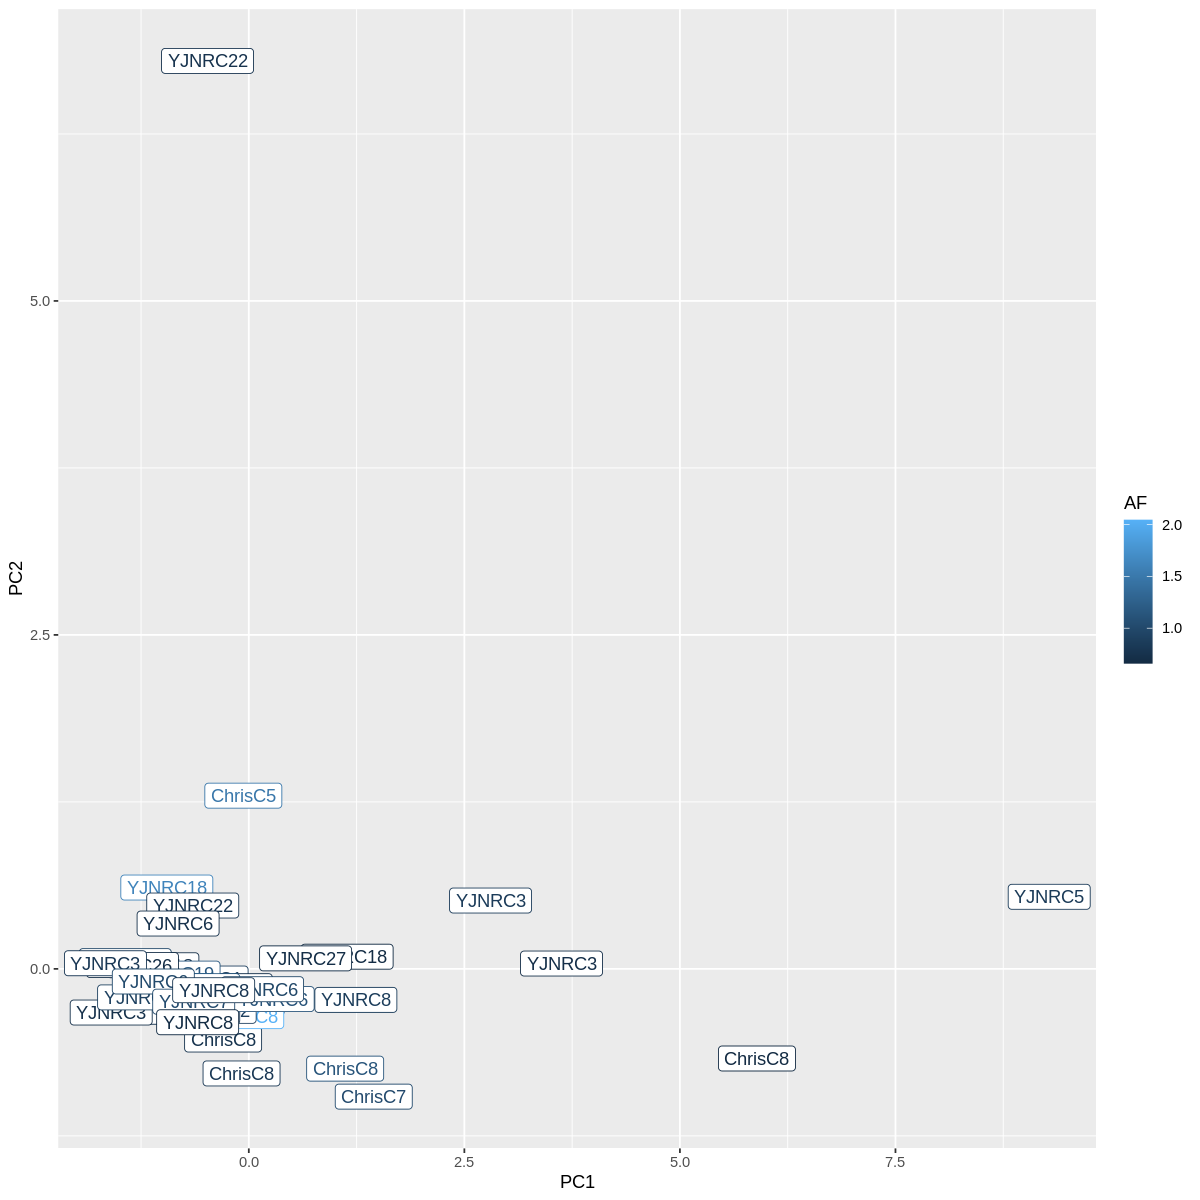

In [54]:
pca_df<-bind_cols(clustering_subset,as.data.frame(prcomp(select(clustering_subset, -AF))$x))
pca_df<-bind_cols(pca_df, data.table(row=OneTable_rows_in_clustering_subset))
pca_df<-left_join(pca_df, mutate(One_Table, row=row_number())%>%select(cross,ID,row), by="row")
ggplot(pca_df,
      aes(PC1,PC2,color=AF))+
geom_point()+geom_label(mapping=aes(label=cross))

In [55]:
saveRDS(pca_df, "~/data/trd/genomic_signals_pca.RDS")

In [56]:
cluster_transposed<-t(as.data.frame(select(clustering_subset, -AF)))
colnames(cluster_transposed)<-1:ncol(cluster_transposed)

Warning message:
"package 'PCAtools' was built under R version 4.1.3"
Loading required package: ggrepel

Warning message:
"package 'ggrepel' was built under R version 4.1.3"

Attaching package: 'PCAtools'


The following objects are masked from 'package:stats':

    biplot, screeplot


Warning message:
"Removed 4 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 4 rows containing missing values (`geom_label_repel()`)."
Warning message:
"Removed 3 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 3 rows containing missing values (`geom_label_repel()`)."


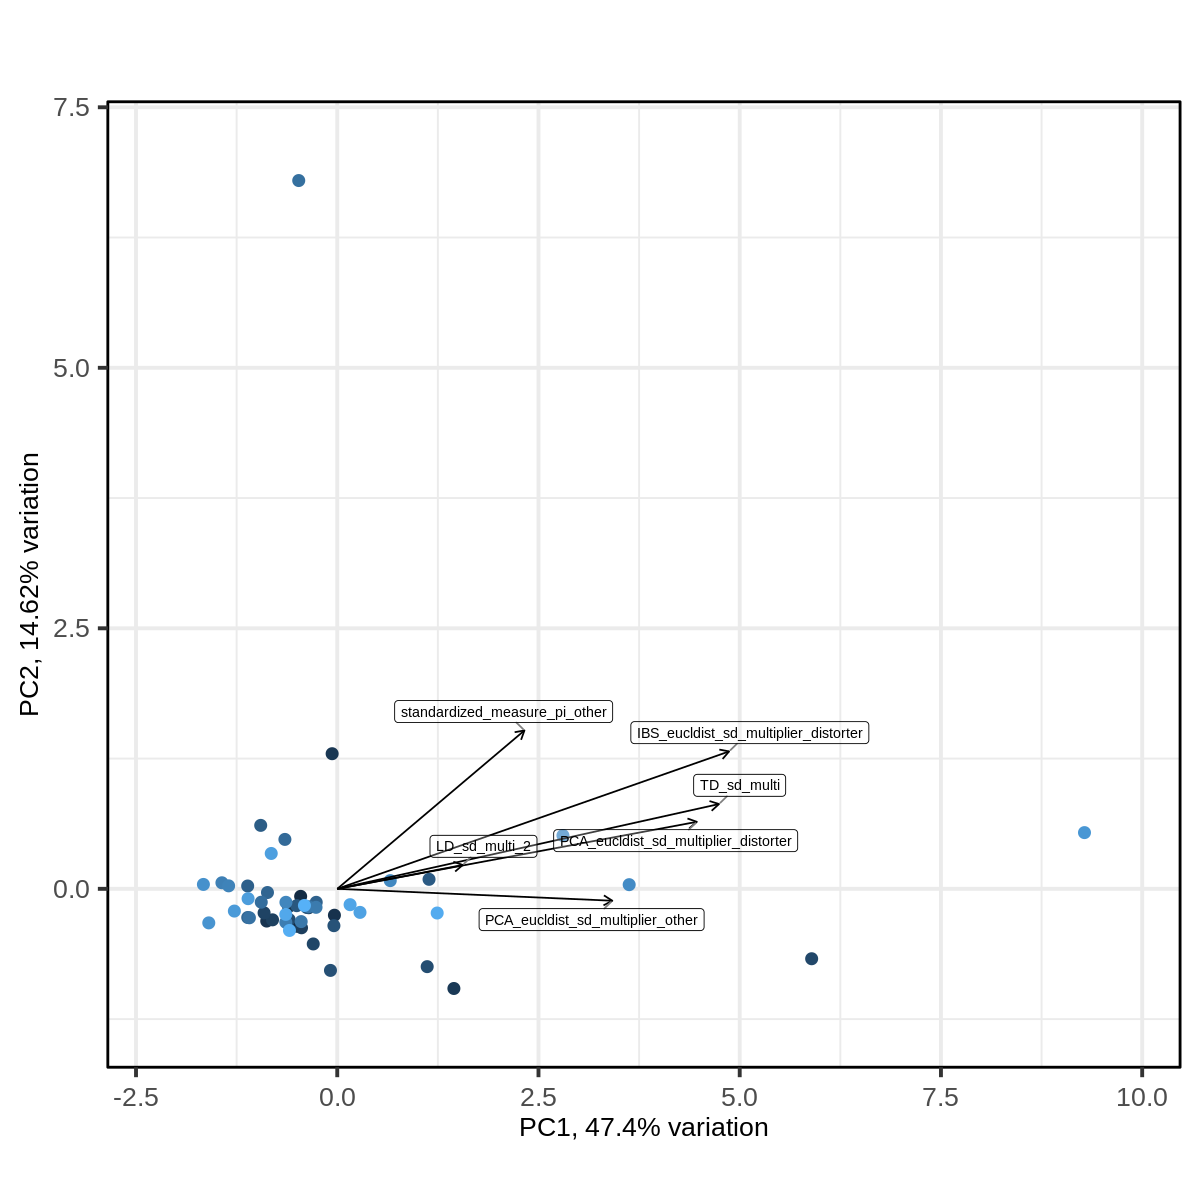

Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_label_repel()`)."


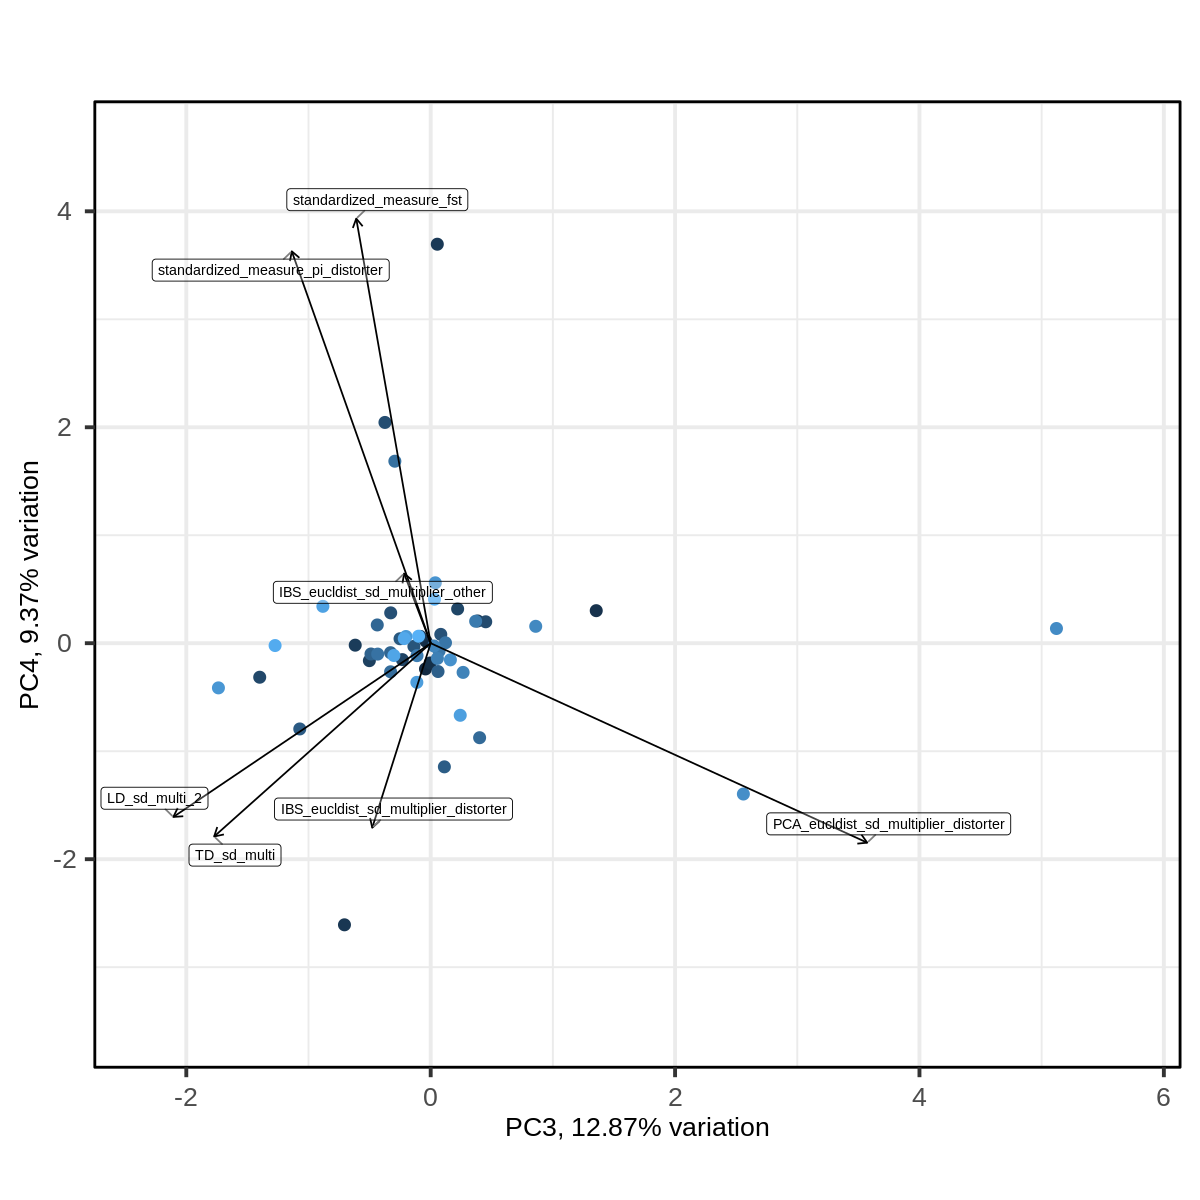

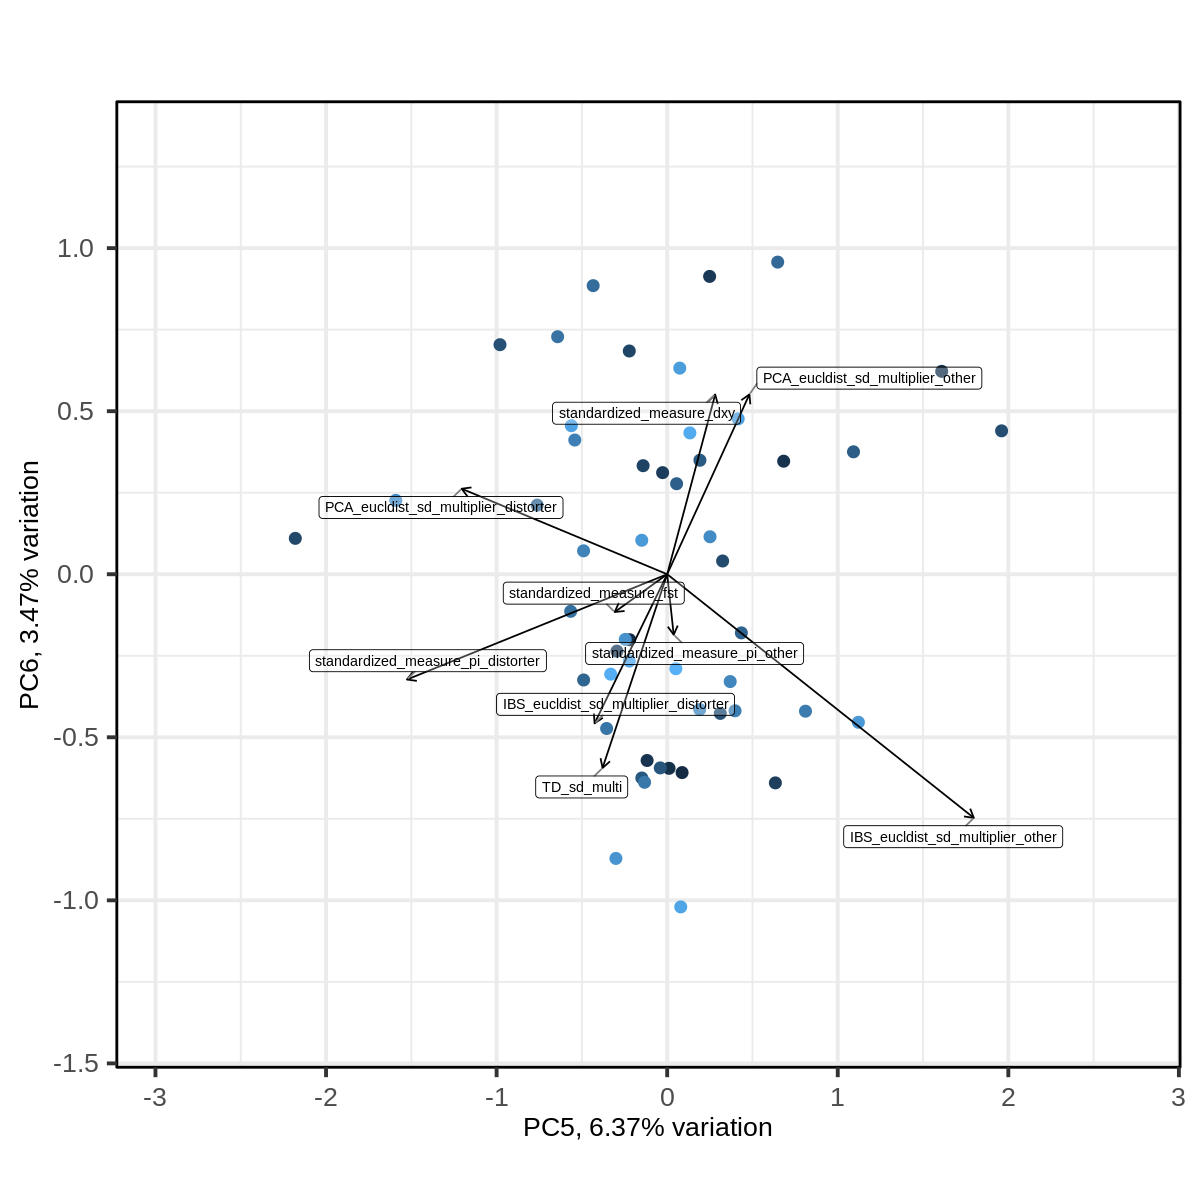

In [57]:
library(PCAtools)
#metadata<-data.frame(row.names = colnames(cluster_transposed), AF=pull(clustering_subset, AF))
p <- pca(cluster_transposed)
biplot(p, showLoadings = TRUE, lab = NULL, showLoadingsNames=TRUE, ntopLoadings=10)
biplot(p, "PC3", "PC4", showLoadings = TRUE, lab = NULL, showLoadingsNames=TRUE, ntopLoadings=10)
biplot(p, "PC5", "PC6", showLoadings = TRUE, lab = NULL, showLoadingsNames=TRUE, ntopLoadings=10)


In [58]:
cor(clustering_subset)

,AF,PCA_eucldist_sd_multiplier_distorter,IBS_eucldist_sd_multiplier_distorter,PCA_eucldist_sd_multiplier_other,IBS_eucldist_sd_multiplier_other,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,LD_sd_multi_2,TD_sd_multi
AF,1.00000000,-0.23247837,-0.2378181,-0.090732338,-0.03859483,-0.21281743,0.123919332,-0.11903483,-0.03201923,0.06756408,-0.15423333
PCA_eucldist_sd_multiplier_distorter,-0.23247837,1.00000000,0.7816638,0.688864214,0.47493225,0.18585268,0.361691156,0.02355975,0.36619255,0.25562341,0.70048135
IBS_eucldist_sd_multiplier_distorter,-0.23781811,0.78166381,1.0000000,0.432536391,0.68214287,0.16788789,0.576761807,0.11337720,0.59065233,0.40571588,0.88593703
PCA_eucldist_sd_multiplier_other,-0.09073234,0.68886421,0.4325364,1.000000000,0.50904830,0.08057730,0.001736552,0.01692405,0.27177273,0.01668245,0.32947948
IBS_eucldist_sd_multiplier_other,-0.03859483,0.47493225,0.6821429,0.509048302,1.00000000,0.14753943,0.363865317,-0.09196507,0.65522714,0.30659568,0.70122180
standardized_measure_pi_distorter,-0.21281743,0.18585268,0.1678879,0.080577302,0.14753943,1.00000000,-0.109684505,-0.32505686,0.46479671,0.01856729,0.23875184
standardized_measure_pi_other,0.12391933,0.36169116,0.5767618,0.001736552,0.36386532,-0.10968451,1.000000000,0.03938881,0.32605066,0.41488517,0.65627570
standardized_measure_fst,-0.11903483,0.02355975,0.1133772,0.016924053,-0.09196507,-0.32505686,0.039388809,1.00000000,0.06978197,-0.01226888,0.08332773
standardized_measure_dxy,-0.03201923,0.36619255,0.5906523,0.271772731,0.65522714,0.46479671,0.326050659,0.06978197,1.00000000,0.37279926,0.62294291
LD_sd_multi_2,0.06756408,0.25562341,0.4057159,0.016682454,0.30659568,0.01856729,0.414885174,-0.01226888,0.37279926,1.00000000,0.44984389


In [59]:
# GO terms

GO_files<-list.files("/home/jnrunge/data/trd/GO_data", full.names = TRUE, pattern="GOdata.RDS$")

# across all samples, I am aggregating all data on "over-represented" (by simple division) GO terms across samples, summarize the frequencies, and then test again against the global distribution.

GO_terms<-bind_rows(lapply(GO_files, readRDS))%>%group_by(GO, Freq, Other)%>%summarize(Freq_TRD=sum(Freq_location),
                                                               Other_TRD=sum(Other_location))%>%arrange(GO)%>%ungroup()
GO_terms<-filter(GO_terms,(Freq_TRD/Other_TRD) > (Freq/Other))
nrow(GO_terms)

GO_terms<-mutate(GO_terms, pChisq=NA)

for(i in 1:nrow(GO_terms)){
        col1<-slice(GO_terms, i)%>%select(Freq_TRD,Other_TRD)%>%t()
        col2<-slice(GO_terms, i)%>%select(Freq,Other)%>%t()
        colnames(col1)<-"col1"
        colnames(col2)<-"col2"
        cols<-bind_cols(col1,col2)
        p_chi<-chisq.test(cols, simulate.p.value = TRUE, B = round((1/(0.05/nrow(GO_terms)))*2))$p.value # 2x as many replicates as would be needed to reach corrected significance if possible
        GO_terms<-mutate(GO_terms, pChisq=ifelse(row_number()==i,
                                                p_chi,
                                                pChisq))
    }

`summarise()` has grouped output by 'GO', 'Freq'. You can override using the `.groups` argument.


[1] 4627





preparing gene to GO mapping data...

preparing IC data...

Warning message in calculateSimMatrix(pull(GO_terms_enriched, GO), orgdb = "org.Sc.sgd.db", :
"Removed 558 terms that were not found in orgdb for BP"


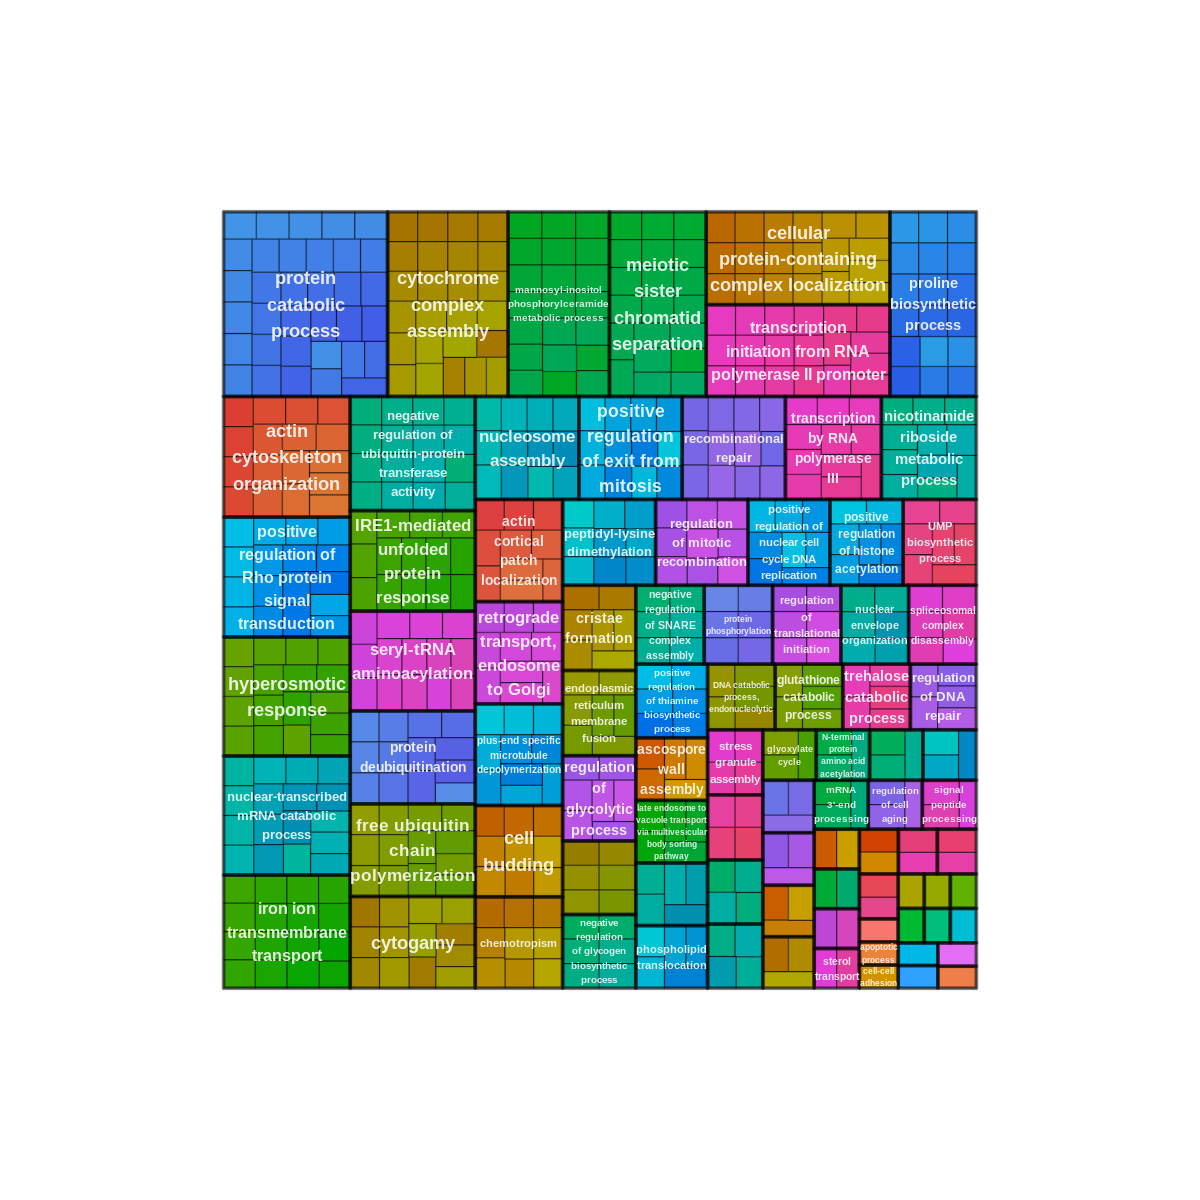

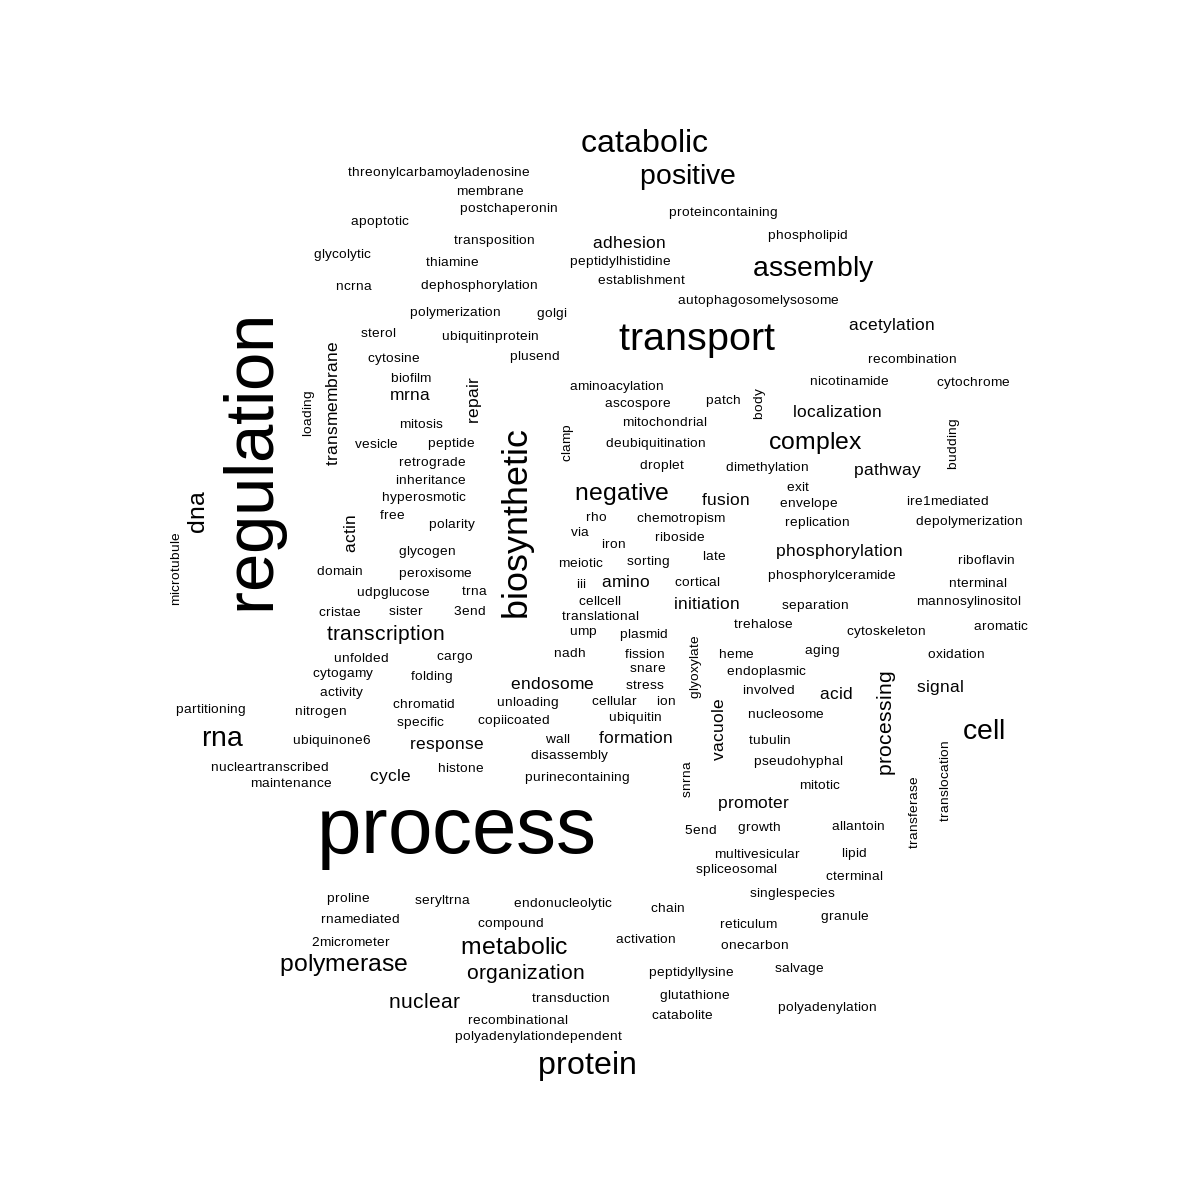

In [60]:
library(rrvgo)

GO_terms_enriched<-filter(GO_terms, pChisq<(0.05/nrow(GO_terms)))

    simMatrix <- calculateSimMatrix(pull(GO_terms_enriched, GO),
                                    orgdb="org.Sc.sgd.db", # yeast Sc 
                                    ont="BP", # biological processes; could also use CC or MF
                                    method="Rel")

    scores <- setNames(-log10(pull(GO_terms_enriched, pChisq)), pull(GO_terms_enriched, GO))
    reducedTerms <- reduceSimMatrix(simMatrix,
                                    scores,
                                    threshold=0.7,
                                    orgdb="org.Sc.sgd.db")


treemapPlot(reducedTerms)
wordcloudPlot(reducedTerms, min.freq=1, colors="black")

In [61]:
saveRDS(reducedTerms, "overall_reducedTerms.RDS")

In [62]:
One_Table<-filter(One_Table, !is.na(lengthBp))

In [63]:
# missing values

missing_overview <- One_Table %>%
  group_by(cross) %>%
  summarise(across(everything(), ~sum(is.na(.x)), .names = "missing_in_{.col}"))

missing_long <- missing_overview %>%
  tidyr::gather(column, missing_count, -cross)
missing_ordered <- missing_long %>% group_by(column)%>%summarize(missing_count=sum(missing_count))%>%
  filter(missing_count > 0) %>%
  arrange(desc(missing_count))
missing_ordered %>%
  rowwise() %>%
  mutate(description = paste("Column", column, "is missing in", missing_count, "regions.")) %>%
  pull(description) %>%
  print()


 [1] "Column missing_in_CONTR is missing in 1 regions."                            
 [2] "Column missing_in_DEL is missing in 1 regions."                              
 [3] "Column missing_in_DUP is missing in 1 regions."                              
 [4] "Column missing_in_INS is missing in 1 regions."                              
 [5] "Column missing_in_INV is missing in 1 regions."                              
 [6] "Column missing_in_TRA is missing in 1 regions."                              
 [7] "Column missing_in_ecdf_value_dxy is missing in 1 regions."                   
 [8] "Column missing_in_ecdf_value_fst is missing in 1 regions."                   
 [9] "Column missing_in_ecdf_value_pi_distorter is missing in 1 regions."          
[10] "Column missing_in_ecdf_value_pi_other is missing in 1 regions."              
[11] "Column missing_in_standardized_measure_dxy is missing in 1 regions."         
[12] "Column missing_in_standardized_measure_fst is missing in 1 regions."  

In [64]:
filter(One_Table, is.na(sum_value_pi_distorter))

ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,PCA_eucldist_quantile_1,...,LD,LD_sd_multi_1,LD_sd_multi_2,TD,TD_sd_multi,TD_ecdf,PCA_eucldist_sd_multiplier_distorter,PCA_eucldist_sd_multiplier_other,IBS_eucldist_sd_multiplier_distorter,IBS_eucldist_sd_multiplier_other
<dbl>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,142,chromosome4,1832928,1892912,59984,YJNRC17,487542,547526,0.970692,...,0.07710305,4.788615,0.5092168,-1.699477,3.850202,0.9929402,3.332181,2.18848,4.576258,3.961712


In [65]:
fwrite(One_Table, "03_OneTable.csv.gz")

In [66]:
SV_data_org<-SV_data

In [ ]:
 # the render function seems to overwrite variables...
for(cross_render in select(One_Table, cross)%>%distinct()%>%pull(cross))
    {
    #if(nrow(filter(SV_data_org, cross==cross_render))==0){
    #    next
    #}
    cross<-cross_render
    print(cross_render)
    rmarkdown::render("03_RegionReportTemplate.Rmd", params = 
                  list(cross=cross),
                  output_file = paste0("~/TRD/03_GenomicSignals/PDF_reports/",cross, '.HTML'), 
                 )
}

